In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
list_tissues_STY = ["Adipose tissue", "B-cells", "Blood", "Bone", "Brain", "Breast",
                "Cerebrospinal fluid", "Cervix", "Colon",
                "Dental plaque", "Esophagus", "Eye", "Follicular fluid", "Heart", "Hela", "Kidney",
                "Liver", "Lung", "Lymph node", "Menstrual fluid", "Monocytes", "Nasal polyps",
               "NK-cells", "Ovary", "Pancreas", "Palatine tonsils", "Parotid gland", "PBMC",
                "Peritoneal dialysis fluid", "Placenta", "Skeletal muscle", "Skin", "Small intestine",
               "Synovial tissue", "T-cells", "Testis", "Tooth", "Umbilical cord", "Ureter",
               "Urinary bladder", "Urine"]

We retrieved disordered region information from MobiDb. The information denotes the disordered regions, the way they ware calculated or retrieved, on which protein they have been identified, the start and end of the disordered region, amongst others. We choose to retain only the following records:

- curated
- predictions from MobiDB and IUPRED
- homology (not from Gene3D and Pfam)

Excluded are:
- homology from Gene3D and Pfam
- interaction interfaces (lip, disorder-to-order transitions, disorder-to-disorder transitions)

In [3]:
mobi1 = pd.read_csv("mobidb_result_2022-03-03T09_47_39.301Z.tsv", sep="\t")
print(mobi1.shape[0])
mobi1.head()

1241631


,acc,feature,start..end,content_fraction,content_count,length
0,C0HLV8,prediction-disorder-th_50,"1..4,22..31",0.452,14,31
1,C0HLV8,prediction-low_complexity-merge,8..17,0.323,10,31
2,C0HLV8,prediction-disorder-iups,"1..4,25..31",0.355,11,31
3,C0HLV8,prediction-disorder-espN,"1..3,28..31",0.226,7,31
4,C0HLV8,prediction-disorder-espD,1..31,1.000,31,31


In [4]:
mobi1[mobi1["feature"].str.contains("th_90")]["feature"].value_counts()

derived-observed-th_90                              7269
derived-missing_residues-th_90                      5448
derived-missing_residues_context_dependent-th_90    5045
derived-mobile_context_dependent-th_90              1974
derived-mobile-th_90                                1803
derived-lip-th_90                                   1757
Name: feature, dtype: int64

In [5]:
mobi1[mobi1["feature"].str.contains("prediction")]["feature"].value_counts()

prediction-disorder-espX                               77660
prediction-disorder-th_50                              77629
prediction-disorder-iups                               77579
prediction-disorder-glo                                77356
prediction-disorder-espN                               76060
prediction-disorder-vsl                                69541
prediction-disorder-dis465                             69260
prediction-disorder-disHL                              69260
prediction-disorder-iupl                               62131
prediction-lip-anchor                                  57042
prediction-low_complexity-merge                        53261
prediction-low_complexity-seg                          47313
prediction-disorder-espD                               46079
prediction-disorder-mobidb_lite                        34865
prediction-low_complexity-pfilt                        26899
prediction-plddt-alphafold                             19960
prediction-polyampholyte

In [6]:
mobi1[(mobi1["feature"].str.contains("curated"))|((mobi1["feature"].str.contains("homology")&(mobi1["feature"].str.contains("homology-domain")==False)))
     ]["feature"].value_counts()

curated-disorder-priority                              1189
curated-disorder-merge                                 1189
homology-disorder-merge                                1074
homology-disorder-priority                             1059
homology-disorder-disprot                               823
curated-disorder-disprot                                722
curated-disorder-ideal                                  679
homology-lip-merge                                      621
curated-lip-merge                                       620
curated-lip-priority                                    618
homology-lip-priority                                   588
homology-conformational_diversity-merge                 463
homology-conformational_diversity-codnas                463
homology-disorder-ideal                                 411
curated-conformational_diversity-codnas                 385
curated-conformational_diversity-merge                  385
homology-lip-disprot                    

In [7]:
mobi1[(mobi1["feature"].str.contains("curated")==False)&
           (mobi1["feature"].str.contains("lip")==True)&(mobi1["feature"].str.contains("homology-disorder-uniprot")==False)
    ]["feature"].value_counts()

prediction-lip-anchor      57042
prediction-lip-priority     2273
derived-lip-merge           2248
derived-lip-th_90           1757
derived-lip-priority        1531
homology-lip-merge           621
homology-lip-priority        588
homology-lip-disprot         338
homology-lip-dibs            229
homology-lip-ideal           104
homology-lip-mfib             80
homology-lip-elm              32
Name: feature, dtype: int64

We retain only the following records from the MobiDB database:
- curated records
- disorder predictions by mobidb-lite
- disorder predictions by iups and iupl (predessor of mobidb-lite)
- homology annotations, but not the ones retrieved from Gene3D and Pfam (Pfam has been considered seperately)

We additionally don't consider records associated with interaction interfaces (lip and binding-mode containing records), as these are considered seperately later on.

In [8]:
mobi = mobi1[(((mobi1["feature"].str.contains("curated"))|(mobi1["feature"].str.contains("disorder-mobidb_lite"))|
               (mobi1["feature"].str.contains("prediction-disorder-iups"))|(mobi1["feature"].str.contains("prediction-disorder-iupl"))|
           ((mobi1["feature"].str.contains("homology"))&(mobi1["feature"].str.contains("homology-domain")==False)))&
                                                               ((mobi1["feature"].str.contains("lip")==False)&
                                                               (mobi1["feature"].str.contains("binding_mode")==False)))]
mobi.rename(columns={"acc": "ACC_ID"}, inplace=True)
print(mobi.shape[0])
mobi.head()

183635


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1740/2598111647.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobi.rename(columns={"acc": "ACC_ID"}, inplace=True)


,ACC_ID,feature,start..end,content_fraction,content_count,length
2,C0HLV8,prediction-disorder-iups,"1..4,25..31",0.355,11,31
15,A0A7P0T821,prediction-disorder-iupl,"4..5,8..24,48..60",0.533,32,60
16,A0A7P0T821,prediction-disorder-iups,"1..10,14..24,52..60",0.500,30,60
28,A0A7P0TA09,prediction-disorder-iups,"1..5,254..256",0.031,8,256
37,A0A7P0T8G2,prediction-disorder-iupl,"1..4,6..17,24..29,43..44,48..49,52..52,67..68,...",0.391,109,279


In [9]:
mobi["feature"].value_counts()

prediction-disorder-iups                    77579
prediction-disorder-iupl                    62131
prediction-disorder-mobidb_lite             34865
curated-disorder-priority                    1189
curated-disorder-merge                       1189
homology-disorder-merge                      1074
homology-disorder-priority                   1059
homology-disorder-disprot                     823
curated-disorder-disprot                      722
curated-disorder-ideal                        679
homology-conformational_diversity-merge       463
homology-conformational_diversity-codnas      463
homology-disorder-ideal                       411
curated-conformational_diversity-merge        385
curated-conformational_diversity-codnas       385
curated-phase_separation-merge                 55
curated-phase_separation-phasepro              55
homology-phase_separation-merge                40
homology-phase_separation-phasepro             40
curated-disorder-uniprot                       26


In [10]:
data_site= pd.read_csv("site_data", sep="\t")
data_site.head()

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Small intestine,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine,Total
0,A0A075B6H7,30,Lung,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,A0A075B6S5,52,Menstrual fluid,S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,A0A087WXM9,223,Testis,S,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,A0A0B4J2D5,124,PBMC,S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,A0A0B4J2D5,145,PBMC,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
proteins_mobi = pd.merge(mobi, data_site[["ACC_ID", "UP_POS"]], on="ACC_ID", how="inner")
print(proteins_mobi.shape[0])
proteins_mobi.head()

82923


,ACC_ID,feature,start..end,content_fraction,content_count,length,UP_POS
0,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,32
1,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,39
2,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,47
3,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,65
4,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,66


In [12]:
proteins_mobi1 = proteins_mobi["start..end"].str.split(",", expand=True)

In [13]:
proteins_mobi = pd.merge(proteins_mobi, proteins_mobi1, how="inner", left_index=True, right_index=True)
print(proteins_mobi.shape[0])
proteins_mobi.head()

82923


,ACC_ID,feature,start..end,content_fraction,content_count,length,UP_POS,0,1,2,...,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040
0,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,32,2..2,8..9,12..12,...,None,None,None,None,None,None,None,None,None,None
1,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,39,2..2,8..9,12..12,...,None,None,None,None,None,None,None,None,None,None
2,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,47,2..2,8..9,12..12,...,None,None,None,None,None,None,None,None,None,None
3,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,65,2..2,8..9,12..12,...,None,None,None,None,None,None,None,None,None,None
4,P31946,prediction-disorder-iupl,"2..2,8..9,12..12,25..26,29..34,36..36,65..84,1...",0.248,61,246,66,2..2,8..9,12..12,...,None,None,None,None,None,None,None,None,None,None


In [14]:
proteins_mobi_sub_tot = pd.DataFrame({})
for i in range (1041):
    proteins_mobi_sub = proteins_mobi.loc[proteins_mobi["UP_POS"].astype(float, copy=False).between(proteins_mobi[i].str.partition("..")[0].astype(float, copy=False), proteins_mobi[i].str.partition("..")[2].astype(float, copy=False))]
    proteins_mobi_sub_tot = proteins_mobi_sub_tot.append(proteins_mobi_sub, ignore_index=True)
    if (i%10)==0:
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040


In [ ]:
for i in range(1041):
    proteins_mobi_sub_tot.drop(i, axis=1, inplace=True)
print(proteins_mobi_sub_tot.shape[0])
print(proteins_mobi_sub_tot["ACC_ID"].nunique())
proteins_mobi_sub_tot.head()

In [ ]:
#proteins_mobi_sub_tot.to_csv("Mobi_DB annotation_proteins", sep="\t", index=False)

We'll now add this data to the three categories of phosphosites respectively.

# 1. Tissue-specific P-sites, tissue aspecific P-sites, pervasive P-sites

We have selected disordered regions from MobiDB based on where MobiDB has retrieved its information, or where it has been identified, and limited this to the regions in which a phosphosites from our dataset is present. We'll now combine this data with the phosphosite data.

In [14]:
proteins_mobi_sub_tot = pd.read_csv("Mobi_DB annotation_proteins", sep="\t")

In [15]:
t_spec_sites = pd.read_csv("1.2 tissue-specific sites.tsv", sep="\t")
non_t_spec_sites = pd.read_csv("1.2 non tissue-specific sites.tsv", sep="\t")
general_P_sites = pd.read_csv("1.2 general P sites.tsv", sep="\t")

In [16]:
print(t_spec_sites.shape[0])
print(t_spec_sites["ACC_ID"].nunique())
tspec_sites_mobi = pd.merge(t_spec_sites, proteins_mobi_sub_tot, how="inner", on=["ACC_ID", "UP_POS"])
print(tspec_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspec_sites_mobi["ACC_ID"].nunique())
tspec_sites_mobi.head()

14019
4977
9312
3388


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-mobidb_lite,1..108,1.000,108,108
1,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iupl,1..108,1.000,108,108
2,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iups,"1..33,37..51,53..108",0.963,104,108
3,A0A1B0GTU1,491,Colon,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-mobidb_lite,"140..194,223..351,364..433,449..468,481..506,7...",0.486,391,805
4,A0A1B0GTU1,491,Colon,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iupl,"100..200,216..216,220..433,437..437,443..511,5...",0.733,590,805


In [17]:
print(non_t_spec_sites.shape[0])
print(non_t_spec_sites["ACC_ID"].nunique())
taspec_sites_mobi = pd.merge(non_t_spec_sites, proteins_mobi_sub_tot, how="inner", on=["ACC_ID", "UP_POS"])
print(taspec_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(taspec_sites_mobi["ACC_ID"].nunique())
taspec_sites_mobi.head()

6478
2718
4579
2003


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0AVK6,102,"Blood,Blood,Colon,Colon,Colon,Colon,Colon",S,0,0,1,0,0,0,...,0,0,0,0,2,prediction-disorder-iupl,"1..31,33..62,68..70,77..85,94..96,99..110,112....",0.506,439,867
1,A0FGR8,738,"Liver,Liver,Liver,Liver,Blood,Testis,Lymph nod...",S,0,0,1,0,0,0,...,0,0,0,0,4,prediction-disorder-mobidb_lite,"1..103,660..754",0.215,198,921
2,A0FGR8,738,"Liver,Liver,Liver,Liver,Blood,Testis,Lymph nod...",S,0,0,1,0,0,0,...,0,0,0,0,4,prediction-disorder-iups,"1..103,457..459,551..556,559..567,573..573,603...",0.256,236,921
3,A0FGR8,738,"Liver,Liver,Liver,Liver,Blood,Testis,Lymph nod...",S,0,0,1,0,0,0,...,0,0,0,0,4,prediction-disorder-iupl,"1..34,37..45,47..104,519..521,552..572,576..57...",0.353,325,921
4,A0FGR8,739,"Liver,Blood,Blood,Colon,Lymph node,Lymph node,...",S,0,0,1,0,0,0,...,0,0,0,0,4,prediction-disorder-mobidb_lite,"1..103,660..754",0.215,198,921


In [18]:
print(general_P_sites.shape[0])
print(general_P_sites["ACC_ID"].nunique())
gen_sites_mobi = pd.merge(general_P_sites, proteins_mobi_sub_tot, how="inner", on=["ACC_ID", "UP_POS"])
print(gen_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(gen_sites_mobi["ACC_ID"].nunique())
gen_sites_mobi.head()

3406
1368
2369
1004


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0JNW5,1402,"Blood,Blood,Blood,Blood, Cerebrospinal fluid, ...",S,0,0,1,0,1,0,...,0,0,0,0,8,prediction-disorder-mobidb_lite,"267..297,409..436,1066..1089,1164..1183,1392.....",0.085,125,1464
1,A0JNW5,1402,"Blood,Blood,Blood,Blood, Cerebrospinal fluid, ...",S,0,0,1,0,1,0,...,0,0,0,0,8,prediction-disorder-iups,"1..6,93..108,110..110,267..292,295..297,407..4...",0.182,267,1464
2,A0JNW5,1402,"Blood,Blood,Blood,Blood, Cerebrospinal fluid, ...",S,0,0,1,0,1,0,...,0,0,0,0,8,prediction-disorder-iupl,"93..109,265..294,297..297,340..348,409..434,59...",0.201,294,1464
3,A2RU30,454,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,0,0,0,0,7,prediction-disorder-iupl,"32..53,152..152,181..183,266..281,298..317,327...",0.405,211,521
4,A5PKW4,68,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",T,0,0,1,0,1,0,...,0,0,0,0,7,prediction-disorder-mobidb_lite,"25..98,113..230,246..402,430..536,976..1024",0.493,505,1024


In [19]:
print(tspec_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0]*100/t_spec_sites.shape[0])
print(taspec_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0]*100/non_t_spec_sites.shape[0])
print(gen_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0]*100/general_P_sites.shape[0])

66.42413866894928
70.685396727385
69.55372871403405


Similar to previous findings, tissue-specific P-sites seem underrepresented. We have also established that the distribution of P-sites across tissues, is similar to the overal distribution of P-sites (regardless of presence or absence in disordered region).

! Important: Because of the way MobiDB is organised, multiple records can cover the same region and thus the same P-site. We therefore (usually) summarise the information on the P-site level, thus representing the amount of P-sites. This is the case unless otherwise indicated.

<AxesSubplot:title={'center':'Number of phosphosites in a disordered region'}, xlabel='Tissue'>

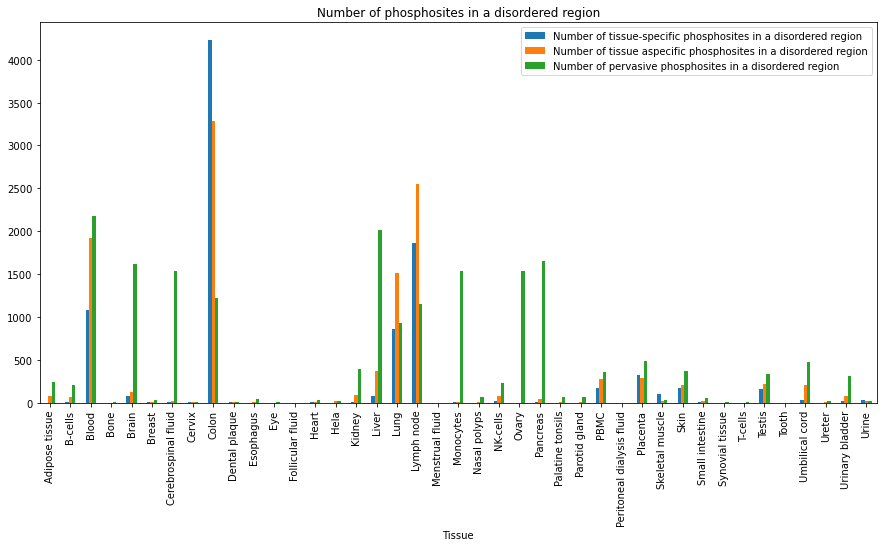

In [20]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspec_sites_mobi.loc[tspec_sites_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = taspec_sites_mobi.loc[taspec_sites_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = gen_sites_mobi.loc[gen_sites_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["ACC_ID"].count()
    count_taspec = loc_taspec["ACC_ID"].count()
    count_gen = loc_gen["ACC_ID"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues = pd.DataFrame({"Tissue": list_tissues_STY, "Number of tissue-specific phosphosites in a disordered region": tspec_counts,
                             "Number of tissue aspecific phosphosites in a disordered region": taspec_counts,
                             "Number of pervasive phosphosites in a disordered region": gen_counts})
distr_tissues.plot(x="Tissue", kind="bar", figsize=(15,7), title="Number of phosphosites in a disordered region")
#plt.savefig("WP2 MobiDB_tissues_phosphosites.png", format="png", bbox_inches="tight")

In [21]:
distr_tissues

,Tissue,Number of tissue-specific phosphosites in a disordered region,Number of tissue aspecific phosphosites in a disordered region,Number of pervasive phosphosites in a disordered region
0,Adipose tissue,0,84,245
1,B-cells,14,69,202
2,Blood,1081,1925,2172
3,Bone,0,1,4
4,Brain,81,128,1615
5,Breast,7,6,34
6,Cerebrospinal fluid,5,17,1539
7,Cervix,5,4,7
8,Colon,4225,3281,1222
9,Dental plaque,6,4,11


In [22]:
#distr_tissues.to_csv("2.3 number of phosphosites in each category per tissue in disordered regions", sep="\t")

We now continue to investigate the P-sites not identified in disordered regions.

In [23]:
missing_tspec = pd.merge(t_spec_sites, tspec_sites_mobi, how="outer", on=["ACC_ID", "UP_POS"], indicator=True)
missing_tspec = missing_tspec[missing_tspec["_merge"]=="left_only"]
print(missing_tspec["ACC_ID"].nunique())
print(missing_tspec.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
missing_tspec.drop(["feature", "start..end", "content_fraction",
                  "content_count", "length", "_merge"], axis=1, inplace=True)
for tissue in list_tissues_STY:
    missing_tspec.drop([tissue+"_y"], axis=1, inplace=True)
missing_tspec.drop(["Total_y"], axis=1, inplace=True)
missing_tspec

2472
4707


,ACC_ID,UP_POS,tissue_x,modres_x,Adipose tissue_x,B-cells_x,Blood_x,Bone_x,Brain_x,Breast_x,...,T-cells_x,Testis_x,Tooth_x,Umbilical cord_x,Ureter_x,Urinary bladder_x,Urine_x,Total_x,tissue_y,modres_y
0,A0A075B6H7,30,Lung,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
1,A0A075B6S5,52,Menstrual fluid,S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
2,A0A087WXM9,223,Testis,S,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,NaN,NaN
3,A0A0B4J2D5,124,PBMC,S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
4,A0A0B4J2D5,145,PBMC,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29571,Q9Y6R7,4801,"Small intestine,Small intestine,Small intestin...",Y,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
29572,Q9Y6R7,5062,"Small intestine,Small intestine,Small intestin...",T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
29588,Q9Y6W5,103,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN
29589,Q9Y6W5,104,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,NaN


In [24]:
missing_nontspec = pd.merge(non_t_spec_sites, taspec_sites_mobi, how="outer", on=["ACC_ID", "UP_POS"], indicator=True)
missing_nontspec = missing_nontspec[missing_nontspec["_merge"]=="left_only"]
print(missing_nontspec["ACC_ID"].nunique())
print(missing_nontspec.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
missing_nontspec.drop(["feature", "start..end", "content_fraction",
                  "content_count", "length", "_merge"], axis=1, inplace=True)
for tissue in list_tissues_STY:
    missing_nontspec.drop([tissue+"_y"], axis=1, inplace=True)
missing_nontspec.drop(["Total_y"], axis=1, inplace=True)
missing_nontspec.head()

1099
1899


,ACC_ID,UP_POS,tissue_x,modres_x,Adipose tissue_x,B-cells_x,Blood_x,Bone_x,Brain_x,Breast_x,...,T-cells_x,Testis_x,Tooth_x,Umbilical cord_x,Ureter_x,Urinary bladder_x,Urine_x,Total_x,tissue_y,modres_y
0,A0A0C4DH36,108,"Lung,Blood,Blood",T,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,NaN,NaN
1,A0AVK6,71,"Blood,Colon,Colon,Colon,Colon,Colon",S,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,NaN,NaN
14,A0M8Q6,31,"Nasal polyps, Palatine tonsils, Parotid gland,...",S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,NaN,NaN
23,A1L390,76,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,NaN,NaN
26,A3KN83,214,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,NaN,NaN


In [25]:
missing_genP = pd.merge(general_P_sites, gen_sites_mobi, how="outer", on=["ACC_ID", "UP_POS"], indicator=True)
missing_genP = missing_genP[missing_genP["_merge"]=="left_only"]
print(missing_genP["ACC_ID"].nunique())
print(missing_genP.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
missing_genP.drop(["feature", "start..end", "content_fraction",
                  "content_count", "length", "_merge"], axis=1, inplace=True)
for tissue in list_tissues_STY:
    missing_genP.drop([tissue+"_y"], axis=1, inplace=True)
missing_genP.drop(["Total_y"], axis=1, inplace=True)
missing_genP.head()

527
1037


,ACC_ID,UP_POS,tissue_x,modres_x,Adipose tissue_x,B-cells_x,Blood_x,Bone_x,Brain_x,Breast_x,...,T-cells_x,Testis_x,Tooth_x,Umbilical cord_x,Ureter_x,Urinary bladder_x,Urine_x,Total_x,tissue_y,modres_y
0,A0A0C4DH39,51,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,0,0,0,0,0,0,0,7,NaN,NaN
5,A5A3E0,939,"Skin,Colon,Colon,Colon,Colon,Colon,Colon,Colon...",S,0,0,1,0,1,0,...,0,0,0,0,0,0,0,11,NaN,NaN
6,A5A3E0,940,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",Y,1,0,1,0,1,0,...,0,1,0,1,0,0,0,13,NaN,NaN
7,A5A3E0,971,"Liver,PBMC,PBMC,Urinary bladder, Colon, Kidney...",S,0,0,1,0,1,0,...,0,0,0,0,0,1,0,15,NaN,NaN
8,A5A3E0,1062,"Breast,Breast,Breast,Breast,Breast,Breast,Brea...",Y,1,0,0,0,0,1,...,0,0,0,1,0,0,0,6,NaN,NaN


We add the amount of missing P-sites, per tissue, per category, to the dataframe that contains the number of sites in each of the three categories. The loss of P-sites seems to be spread in accordance to the number of sites identified as being tissue-specific, tissue aspecific and pervasive P-sites.

In [26]:
list_missing_tspec = []
list_missing_nontspec = []
list_missing_genP = []
list_all_tspec = []
list_all_genP = []
for tissue in list_tissues_STY:
    tissue=tissue+"_x"
    count_missing_tspec = missing_tspec[tissue].sum()
    count_missing_nontspec = missing_nontspec[tissue].sum()
    count_missing_genP = missing_genP[tissue].sum()
    list_missing_tspec.append(count_missing_tspec)
    list_missing_nontspec.append(count_missing_nontspec)
    list_missing_genP.append(count_missing_genP)
missing = pd.read_csv("number of three categories per tissue_sites.tsv", sep="\t")
missing["tissue-specific phosphosites outside a disordered region"] = list_missing_tspec
missing["tissue aspecific phosphosites outside a disordered region"] = list_missing_nontspec
missing["pervasive phosphosites outside a disordered region"] = list_missing_genP

<AxesSubplot:title={'center':'Phosphosites not occuring in a disordered region'}, xlabel='Tissue'>

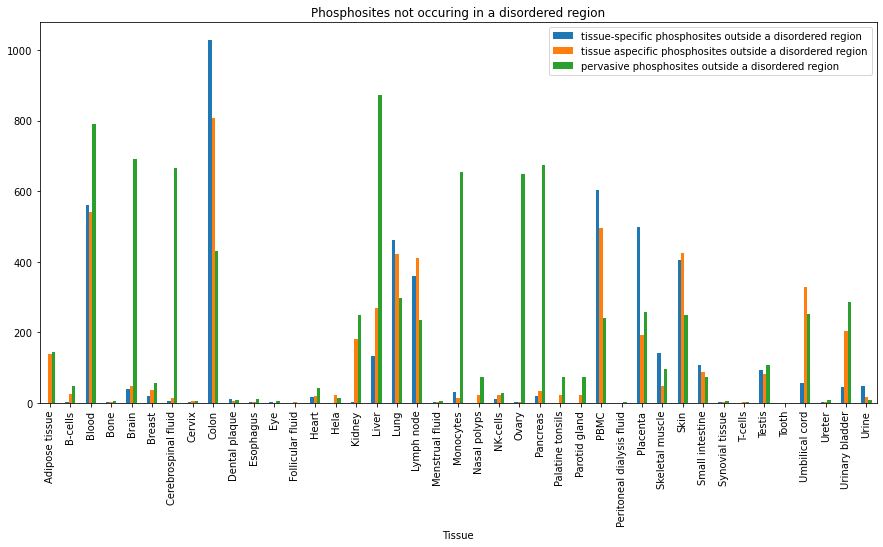

In [27]:
missing[["Tissue", "tissue-specific phosphosites outside a disordered region", "tissue aspecific phosphosites outside a disordered region", "pervasive phosphosites outside a disordered region"]].plot(x="Tissue", kind="bar", figsize=(15,7), title="Phosphosites not occuring in a disordered region")

In [28]:
missing

,Tissue,number of tissue-specific sites,number of non tissue-specific sites,number of generally expressed sites,Total,tissue-specific phosphosites outside a disordered region,tissue aspecific phosphosites outside a disordered region,pervasive phosphosites outside a disordered region
0,Adipose tissue,0,221,390,611,0,137,145
1,B-cells,16,95,250,361,2,26,48
2,Blood,1642,2466,2961,7069,561,541,789
3,Bone,2,2,9,13,2,1,5
4,Brain,121,176,2307,2604,40,48,692
5,Breast,26,42,89,157,19,36,55
6,Cerebrospinal fluid,9,30,2203,2242,4,13,664
7,Cervix,7,8,13,28,2,4,6
8,Colon,5252,4089,1651,10992,1027,808,429
9,Dental plaque,17,9,18,44,11,5,7


<AxesSubplot:title={'center':'Comparison of annotated tissue-specific phosphosites compared to non annotated'}, xlabel='Tissue'>

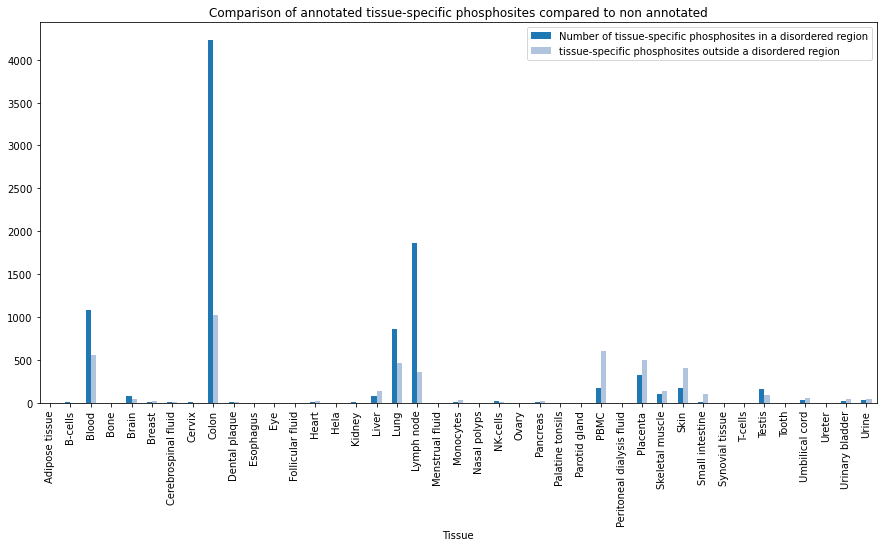

In [29]:
distr_tissues_comp = pd.merge(distr_tissues, missing[["Tissue","tissue-specific phosphosites outside a disordered region", 
                                                     "tissue aspecific phosphosites outside a disordered region",
                                                     "pervasive phosphosites outside a disordered region"]], how="inner", on="Tissue")
distr_tissues_tspec = distr_tissues_comp[["Tissue", "Number of tissue-specific phosphosites in a disordered region", "tissue-specific phosphosites outside a disordered region"]].copy()
distr_tissues_taspec = distr_tissues_comp[["Tissue", "Number of tissue aspecific phosphosites in a disordered region", "tissue aspecific phosphosites outside a disordered region"]]
distr_tissues_gen = distr_tissues_comp[["Tissue", "Number of pervasive phosphosites in a disordered region", "pervasive phosphosites outside a disordered region"]]


distr_tissues_tspec.plot(kind="bar", x="Tissue", color=["tab:blue", "lightsteelblue"], figsize=(15,7), title="Comparison of annotated tissue-specific phosphosites compared to non annotated")

<AxesSubplot:title={'center':'Comparison of annotated tissue aspecific phosphosites compared to non annotated'}, xlabel='Tissue'>

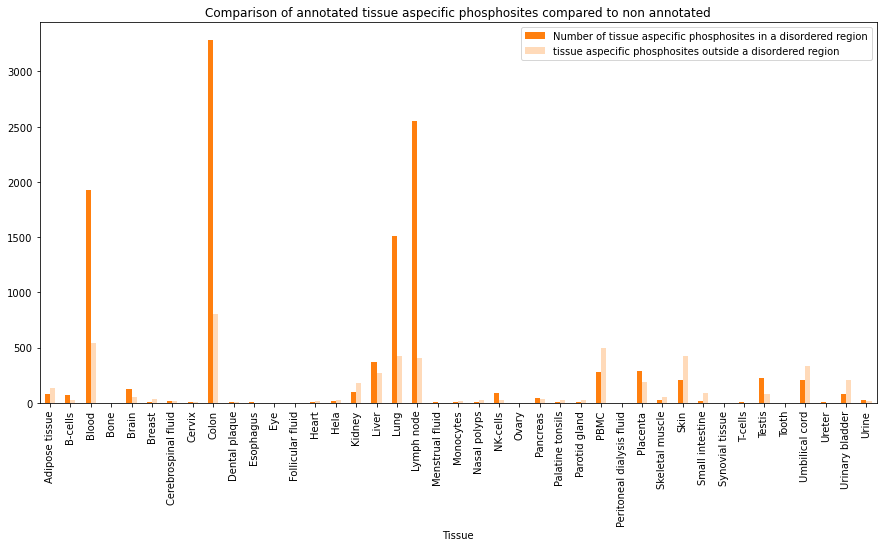

In [30]:
distr_tissues_taspec.plot(kind="bar", x="Tissue", color=["tab:orange","peachpuff"], figsize=(15,7), title="Comparison of annotated tissue aspecific phosphosites compared to non annotated")

<AxesSubplot:title={'center':'Comparison of annotated pervasive phosphosites to non annotated'}, xlabel='Tissue'>

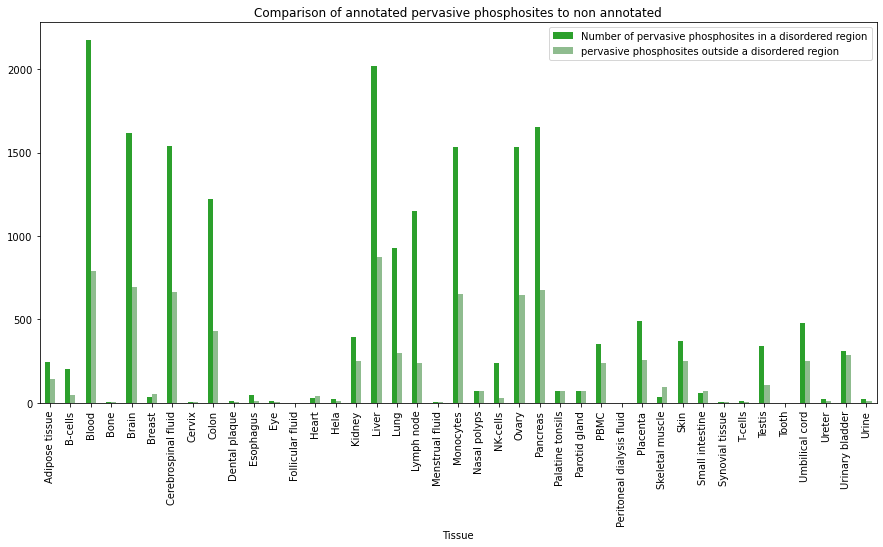

In [31]:
distr_tissues_gen.plot(kind="bar", x="Tissue", color=["tab:green", "darkseagreen"], figsize=(15,7), title="Comparison of annotated pervasive phosphosites to non annotated")

In the figure below, we can clearly see that in some tissues, more P-sites are considered in disordered regions. This does not seem to be linked entirely to the overal representation level (for example blood, lung) and can differ across the categories (lung, placenta).

<Figure size 1080x432 with 0 Axes>

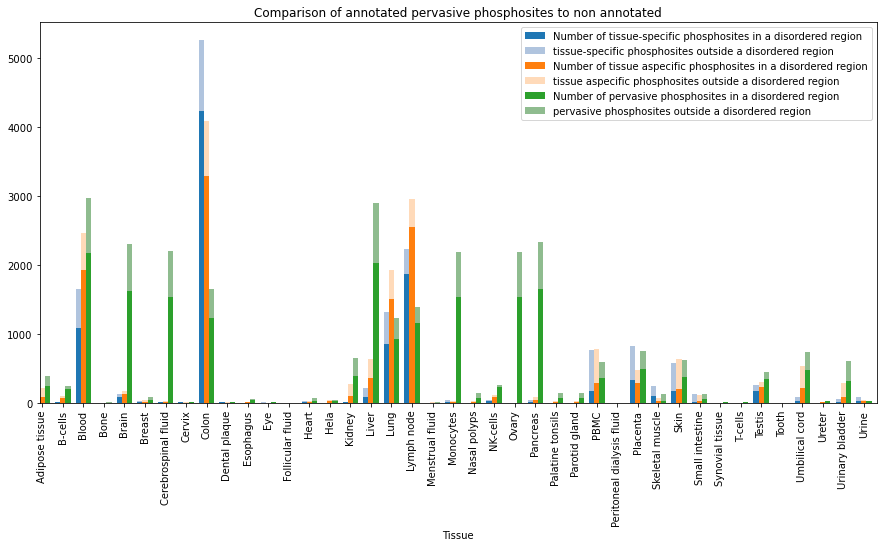

In [32]:
plt.figure(figsize=(15,6))
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
distr_tissues_tspec.plot(kind="bar", x="Tissue", ax=ax, position=1.5, stacked=True, width=0.25, color=["tab:blue", "lightsteelblue"], figsize=(15,7), title="Comparison of annotated tissue-specific phosphosites compared to non annotated")
distr_tissues_taspec.plot(kind="bar", x="Tissue", ax=ax, position=0.5, stacked=True, width=0.25, color=["tab:orange","peachpuff"], figsize=(15,7), title="Comparison of annotated tissue aspecific phosphosites compared to non annotated")
distr_tissues_gen.plot(kind="bar", x="Tissue", ax=ax, position=-0.5, stacked=True, width=0.25, color=["tab:green", "darkseagreen"], figsize=(15,7), title="Comparison of annotated pervasive phosphosites to non annotated")
#plt.savefig("WP2 MobiDB_missing_annotated_sites_per_tissue.png", format="png", bbox_inches="tight")
plt.show()

<Figure size 1080x432 with 0 Axes>

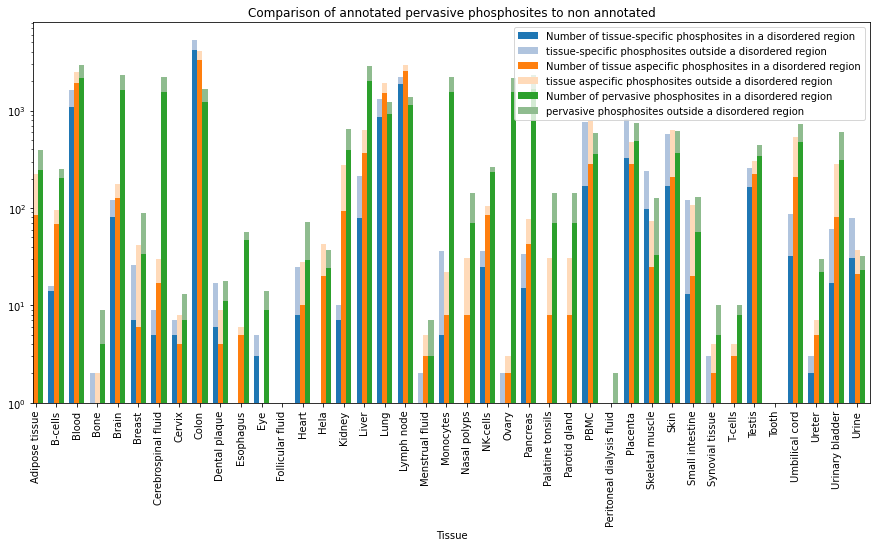

In [33]:
plt.figure(figsize=(15,6))
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
distr_tissues_tspec.plot(kind="bar", x="Tissue", logy=True, ax=ax, position=1.5, stacked=True, width=0.25, color=["tab:blue", "lightsteelblue"], figsize=(15,7), title="Comparison of annotated tissue-specific phosphosites compared to non annotated")
distr_tissues_taspec.plot(kind="bar", x="Tissue", logy=True, ax=ax, position=0.5, stacked=True, width=0.25, color=["tab:orange","peachpuff"], figsize=(15,7), title="Comparison of annotated tissue aspecific phosphosites compared to non annotated")
distr_tissues_gen.plot(kind="bar", x="Tissue", logy=True, ax=ax, position=-0.5, stacked=True, width=0.25, color=["tab:green", "darkseagreen"], figsize=(15,7), title="Comparison of annotated pervasive phosphosites to non annotated")
#plt.savefig("WP2 MobiDB_missing_annotated_sites_per_tissue_lof.png", format="png", bbox_inches="tight")
plt.show()

## Number of sites having disordered regions per category

We'll now, for each category, calculate how many P-sites are annotated with a disordered region. Despite there being less pervasively phorphorylated P-sites, they are much better represented in relative terms. The same is true for the tissue aspecific P-sites.

<AxesSubplot:title={'center':'Number of annotated phosphosites compared to non annotated ones per category'}, xlabel='Label'>

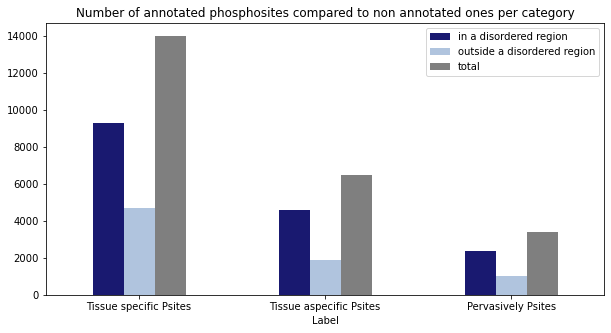

In [34]:
annotated = [tspec_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0], taspec_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0], gen_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0]]
             
missed = [missing_tspec.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0],
          missing_nontspec.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0],
          missing_genP.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0]]

total = [annotated[0]+missed[0], annotated[1]+missed[1], annotated[2]+missed[2]]

three_cat = pd.DataFrame({"Label": ["Tissue specific Psites", "Tissue aspecific Psites",
                                   "Pervasively Psites"], "in a disordered region": annotated, "outside a disordered region": missed, "total":total})
three_cat.plot(kind="bar", x="Label" ,color=["midnightblue", "lightsteelblue", "tab:grey"], figsize=(10,5), title="Number of annotated phosphosites compared to non annotated ones per category", rot=0)
#plt.savefig("WP2 MobiDB_ratio_phosphosites_per_cat.png", format="png", bbox_inches="tight")

In [35]:
three_cat["ratio_annotated"] = three_cat["in a disordered region"]*100/three_cat["total"]
three_cat

,Label,in a disordered region,outside a disordered region,total,ratio_annotated
0,Tissue specific Psites,9312,4707,14019,66.424139
1,Tissue aspecific Psites,4579,1899,6478,70.685397
2,Pervasively Psites,2369,1037,3406,69.553729


In [36]:
tspec_sites_mobi = pd.merge(t_spec_sites, proteins_mobi, on=["ACC_ID"], how="inner")
print(tspec_sites_mobi["ACC_ID"].nunique())
taspec_sites_mobi = pd.merge(non_t_spec_sites, proteins_mobi, on=["ACC_ID"], how="inner")
print(taspec_sites_mobi["ACC_ID"].nunique())
gen_sites_mobi = pd.merge(general_P_sites, proteins_mobi, on=["ACC_ID"], how="inner")
print(gen_sites_mobi["ACC_ID"].nunique())

Uniprot = pd.read_csv("UniprotKB_GO_human_mannually annotated.tab", sep="\t")
Uniprot.rename({"Entry": "ACC_ID"}, axis=1, inplace=True)
Uniprot_mobi = pd.merge(Uniprot["ACC_ID"], mobi, on=["ACC_ID"], how="inner")
print(Uniprot_mobi["ACC_ID"].nunique())

4971
2715
1368
20224


# Proteins having tissue-specific phosphosites

We now specifically consider tissue-specific P-sites, occuring on the three different categories of proteins.

In [37]:
print(t_spec_sites.shape[0])
print(t_spec_sites["ACC_ID"].nunique())
tspec_sites_mobi = pd.merge(t_spec_sites, proteins_mobi_sub_tot, how="inner", on=["ACC_ID", "UP_POS"])
print(tspec_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspec_sites_mobi["ACC_ID"].nunique())
tspec_sites_mobi.head()

14019
4977
9312
3388


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-mobidb_lite,1..108,1.000,108,108
1,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iupl,1..108,1.000,108,108
2,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iups,"1..33,37..51,53..108",0.963,104,108
3,A0A1B0GTU1,491,Colon,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-mobidb_lite,"140..194,223..351,364..433,449..468,481..506,7...",0.486,391,805
4,A0A1B0GTU1,491,Colon,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iupl,"100..200,216..216,220..433,437..437,443..511,5...",0.733,590,805


In [38]:
tspec_proteins = pd.read_csv("1.1 tissue-specific proteins.tsv", sep="\t")
print(tspec_proteins.shape[0])
taspec_proteins = pd.read_csv("1.1 non tissue-specific proteins.tsv", sep="\t")
print(taspec_proteins.shape[0])
gen_proteins = pd.read_csv("1.1 general P proteins", sep="\t")
print(gen_proteins.shape[0])

2029
2074
1752


In [39]:
tspec_sites_mobi = pd.merge(t_spec_sites, proteins_mobi_sub_tot, on=["ACC_ID", "UP_POS"], how="inner")
tspecsites_tspecproteins_mobi = pd.merge(tspec_sites_mobi, tspec_proteins["ACC_ID"], on=["ACC_ID"], how="inner")
tspecsites_tspecproteins_mobi.head()

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-mobidb_lite,1..108,1.000,108,108
1,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iupl,1..108,1.000,108,108
2,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iups,"1..33,37..51,53..108",0.963,104,108
3,A0A1B0GTU1,491,Colon,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-mobidb_lite,"140..194,223..351,364..433,449..468,481..506,7...",0.486,391,805
4,A0A1B0GTU1,491,Colon,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iupl,"100..200,216..216,220..433,437..437,443..511,5...",0.733,590,805


In [40]:
tspecsites_taspecproteins_mobi = pd.merge(tspec_sites_mobi, taspec_proteins["ACC_ID"], on=["ACC_ID"], how="inner")
tspecsites_taspecproteins_mobi.head()

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0AVK6,68,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iupl,"1..31,33..62,68..70,77..85,94..96,99..110,112....",0.506,439,867
1,A0AVK6,68,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iups,"1..10,12..12,20..22,28..29,33..34,36..64,68..6...",0.353,306,867
2,A0JLT2,192,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",T,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-mobidb_lite,"1..56,171..244",0.533,130,244
3,A0JLT2,192,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",T,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iups,"1..57,120..120,161..244",0.582,142,244
4,A0JLT2,192,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",T,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iupl,"2..56,59..65,71..71,77..84,104..104,108..145,1...",0.852,208,244


In [41]:
tspecsites_genproteins_mobi = pd.merge(tspec_sites_mobi, gen_proteins["ACC_ID"], on=["ACC_ID"], how="inner")
tspecsites_genproteins_mobi.head()

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0FGR8,736,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-mobidb_lite,"1..103,660..754",0.215,198,921
1,A0FGR8,736,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iups,"1..103,457..459,551..556,559..567,573..573,603...",0.256,236,921
2,A0FGR8,736,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iupl,"1..34,37..45,47..104,519..521,552..572,576..57...",0.353,325,921
3,A0FGR8,737,Colon,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-mobidb_lite,"1..103,660..754",0.215,198,921
4,A0FGR8,737,Colon,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-disorder-iups,"1..103,457..459,551..556,559..567,573..573,603...",0.256,236,921


In [42]:
print(tspecsites_tspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspecsites_taspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspecsites_genproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])

1548
3420
4344


In [43]:
tspecsites_tspecproteins = pd.merge(t_spec_sites[["ACC_ID", "UP_POS"]], tspec_proteins["ACC_ID"], how="inner", on=["ACC_ID"])
tspecsites_taspecproteins = pd.merge(t_spec_sites[["ACC_ID", "UP_POS"]], taspec_proteins["ACC_ID"], how="inner", on=["ACC_ID"])
tspecsites_genproteins = pd.merge(t_spec_sites[["ACC_ID", "UP_POS"]], gen_proteins["ACC_ID"], how="inner", on=["ACC_ID"])

print(tspecsites_tspecproteins.shape[0])
print(tspecsites_taspecproteins.shape[0])
print(tspecsites_genproteins.shape[0])

2794
4989
6236


Considerably more P-sites on non-tissue-specific phosphorylated proteins have been found in disordered regions.

In [44]:
print(tspecsites_tspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0]*100/tspecsites_tspecproteins.shape[0])
print(tspecsites_taspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0]*100/tspecsites_taspecproteins.shape[0])
print(tspecsites_genproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0]*100/tspecsites_genproteins.shape[0])

55.40443808160344
68.55081178592904
69.6600384862091


<AxesSubplot:title={'center':'Number of tissue-specific phosphosites in a disordered region'}, xlabel='Tissue'>

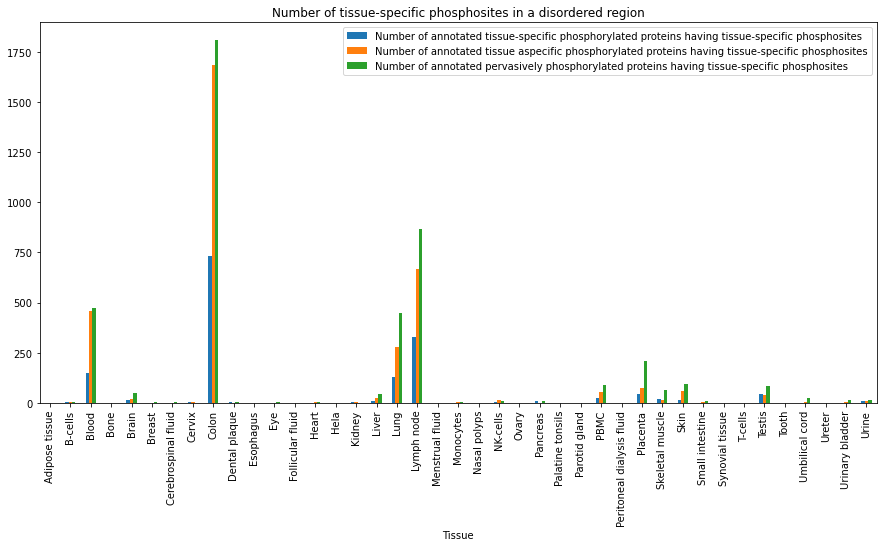

In [45]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspecsites_tspecproteins_mobi.loc[tspecsites_tspecproteins_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = tspecsites_taspecproteins_mobi.loc[tspecsites_taspecproteins_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = tspecsites_genproteins_mobi.loc[tspecsites_genproteins_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["ACC_ID"].count()
    count_taspec = loc_taspec["ACC_ID"].count()
    count_gen = loc_gen["ACC_ID"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues = pd.DataFrame({"Tissue": list_tissues_STY, "Number of annotated tissue-specific phosphorylated proteins having tissue-specific phosphosites": tspec_counts,
                             "Number of annotated tissue aspecific phosphorylated proteins having tissue-specific phosphosites": taspec_counts,
                             "Number of annotated pervasively phosphorylated proteins having tissue-specific phosphosites": gen_counts})
distr_tissues.plot(x="Tissue", kind="bar", figsize=(15,7), title="Number of tissue-specific phosphosites in a disordered region")

In [46]:
tspec_sites_tspecproteins = pd.merge(t_spec_sites, tspec_proteins, on=["ACC_ID"], how="inner")
missing_tspec = pd.merge(tspec_sites_tspecproteins, tspecsites_tspecproteins_mobi, how="outer", on=["ACC_ID", "UP_POS"], indicator=True)
missing_tspec = missing_tspec[missing_tspec["_merge"]=="left_only"]
print(missing_tspec["ACC_ID"].nunique())
print(missing_tspec.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
missing_tspec.drop(["feature", "start..end", "content_fraction",
                  "content_count", "length", "_merge"], axis=1, inplace=True)
for tissue in list_tissues_STY:
    missing_tspec.drop([tissue+"_y"], axis=1, inplace=True)
missing_tspec.drop(["Total_y"], axis=1, inplace=True)
missing_tspec

1023
1246


,ACC_ID,UP_POS,tissue_x,modres_x,Adipose tissue_x,B-cells_x,Blood_x,Bone_x,Brain_x,Breast_x,...,Small intestine,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine,Total
0,A0A075B6H7,30,Lung,T,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A0A075B6S5,52,Menstrual fluid,S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A0A087WXM9,223,Testis,S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A0A0B4J2D5,124,PBMC,S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A0A0B4J2D5,145,PBMC,T,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5116,Q9Y6N5,376,Liver,Y,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5118,Q9Y6R7,224,Small intestine,S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5119,Q9Y6R7,4801,"Small intestine,Small intestine,Small intestin...",Y,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5120,Q9Y6R7,5062,"Small intestine,Small intestine,Small intestin...",T,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
tspec_sites_taspecproteins = pd.merge(t_spec_sites, taspec_proteins, on=["ACC_ID"], how="inner")
missing_nontspec = pd.merge(tspec_sites_taspecproteins, tspecsites_taspecproteins_mobi, how="outer", on=["ACC_ID", "UP_POS"], indicator=True)
missing_nontspec = missing_nontspec[missing_nontspec["_merge"]=="left_only"]
print(missing_nontspec["ACC_ID"].nunique())
print(missing_nontspec.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
missing_nontspec.drop(["feature", "start..end", "content_fraction",
                  "content_count", "length", "_merge"], axis=1, inplace=True)
for tissue in list_tissues_STY:
    missing_nontspec.drop([tissue+"_y"], axis=1, inplace=True)
missing_nontspec.drop(["Total_y"], axis=1, inplace=True)
missing_nontspec.head()

741
1569


,ACC_ID,UP_POS,tissue_x,modres_x,Adipose tissue_x,B-cells_x,Blood_x,Bone_x,Brain_x,Breast_x,...,Small intestine,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine,Total
27,A1KXE4,185,Colon,T,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,A1L390,423,"Colon,Colon",S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,A1L390,741,Colon,S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,A4UGR9,3042,Skeletal muscle,S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,A6ND36,356,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
tspec_sites_genproteins = pd.merge(t_spec_sites, gen_proteins, on=["ACC_ID"], how="inner")
missing_genP = pd.merge(tspec_sites_genproteins, tspecsites_genproteins_mobi, how="outer", on=["ACC_ID", "UP_POS"], indicator=True)
missing_genP = missing_genP[missing_genP["_merge"]=="left_only"]
print(missing_genP["ACC_ID"].nunique())
print(missing_genP.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
missing_genP.drop(["feature", "start..end", "content_fraction",
                  "content_count", "length", "_merge"], axis=1, inplace=True)
for tissue in list_tissues_STY:
    missing_genP.drop([tissue+"_y"], axis=1, inplace=True)
missing_genP.drop(["Total_y"], axis=1, inplace=True)
missing_genP.head()

708
1892


,ACC_ID,UP_POS,tissue_x,modres_x,Adipose tissue_x,B-cells_x,Blood_x,Bone_x,Brain_x,Breast_x,...,Small intestine,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine,Total
18,A0JNW5,933,Lymph node,S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,A0JNW5,939,Blood,S,0,0,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,A0JNW5,953,Lymph node,S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,A5A3E0,949,Skeletal muscle,T,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,A6NEL2,740,"Colon,Colon,Colon,Colon,Colon,Colon,Colon",S,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Tissue-specific phosphosites not occuring in a disordered region'}, xlabel='Tissue'>

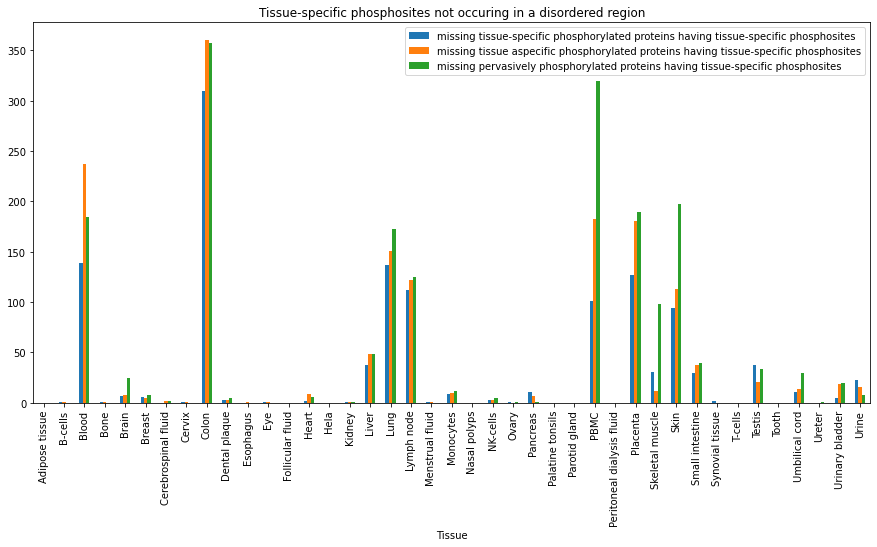

In [49]:
list_missing_tspec = []
list_missing_nontspec = []
list_missing_genP = []
list_all_tspec = []
list_all_genP = []
for tissue in list_tissues_STY:
    tissue=tissue+"_x"
    count_missing_tspec = missing_tspec[tissue].sum()
    count_missing_nontspec = missing_nontspec[tissue].sum()
    count_missing_genP = missing_genP[tissue].sum()
    list_missing_tspec.append(count_missing_tspec)
    list_missing_nontspec.append(count_missing_nontspec)
    list_missing_genP.append(count_missing_genP)
missing = pd.read_csv("number of three categories per tissue_sites.tsv", sep="\t")
missing["missing tissue-specific phosphorylated proteins having tissue-specific phosphosites"] = list_missing_tspec
missing["missing tissue aspecific phosphorylated proteins having tissue-specific phosphosites"] = list_missing_nontspec
missing["missing pervasively phosphorylated proteins having tissue-specific phosphosites"] = list_missing_genP

missing[["Tissue", "missing tissue-specific phosphorylated proteins having tissue-specific phosphosites", "missing tissue aspecific phosphorylated proteins having tissue-specific phosphosites", "missing pervasively phosphorylated proteins having tissue-specific phosphosites"]].plot(x="Tissue", kind="bar", figsize=(15,7), title="Tissue-specific phosphosites not occuring in a disordered region")

In [50]:
distr_tissues_comp = pd.merge(distr_tissues, missing[["Tissue","missing tissue-specific phosphorylated proteins having tissue-specific phosphosites", 
                                                     "missing tissue aspecific phosphorylated proteins having tissue-specific phosphosites",
                                                     "missing pervasively phosphorylated proteins having tissue-specific phosphosites"]], how="inner", on="Tissue")
distr_tissues_tspec = distr_tissues_comp[["Tissue", "Number of annotated tissue-specific phosphorylated proteins having tissue-specific phosphosites", "missing tissue-specific phosphorylated proteins having tissue-specific phosphosites"]].copy()
distr_tissues_taspec = distr_tissues_comp[["Tissue", "Number of annotated tissue aspecific phosphorylated proteins having tissue-specific phosphosites", "missing tissue aspecific phosphorylated proteins having tissue-specific phosphosites"]]
distr_tissues_gen = distr_tissues_comp[["Tissue", "Number of annotated pervasively phosphorylated proteins having tissue-specific phosphosites", "missing pervasively phosphorylated proteins having tissue-specific phosphosites"]]

For the tissue-specific P-sites on tissue-specific phosphorylated proteins, most well-represented tissues show more P-sites in disordered regions. However, for blood and lung the distribution is more 50/50. For the lesser represented tissues, more P-sites were not associated with a disordered region. For the tissue aspecific phosphorylated proteins having tissue-specific P-sites and the pervasively phosphorylated proteins having tissue-specific P-sites, all well-represented tissues show more P-sites in disordered regions, while most less-represented tissues show less P-sites in disordered regions (exceptions: testis for tissue aspecific phosphorylated proteins, and placenta and testis for pervasively phosphorylated proteins). While this trend is true for all tissue-specific P-sites in testis combined, it is not for placenta.

<AxesSubplot:title={'center':'Comparison of annotated tissue-specific phosphorylated proteins having tissue-specific phosphosites compared to non annotated'}, xlabel='Tissue'>

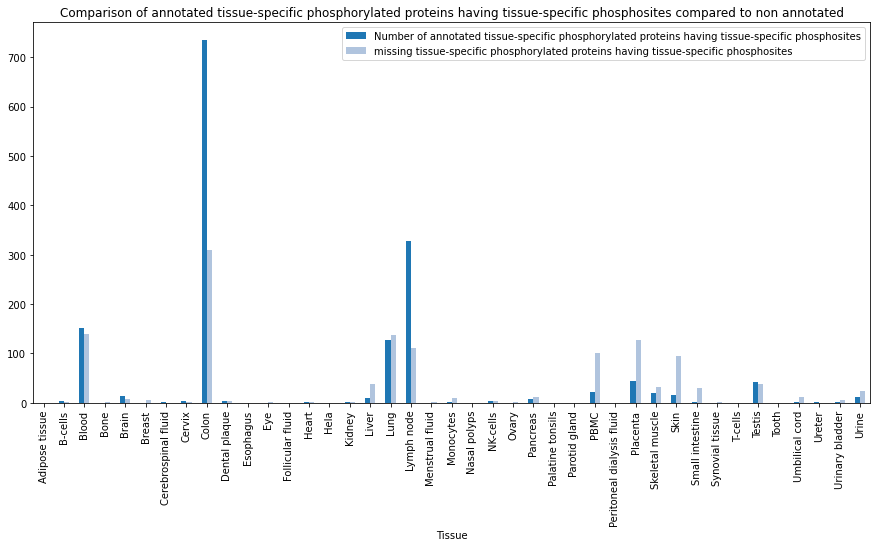

In [51]:
distr_tissues_tspec.plot(kind="bar", x="Tissue", color=["tab:blue", "lightsteelblue"], figsize=(15,7), title="Comparison of annotated tissue-specific phosphorylated proteins having tissue-specific phosphosites compared to non annotated")

<AxesSubplot:title={'center':'Comparison of annotated tissue aspecific phosphorylated proteins having tissue-specific phosphosites compared to non annotated'}, xlabel='Tissue'>

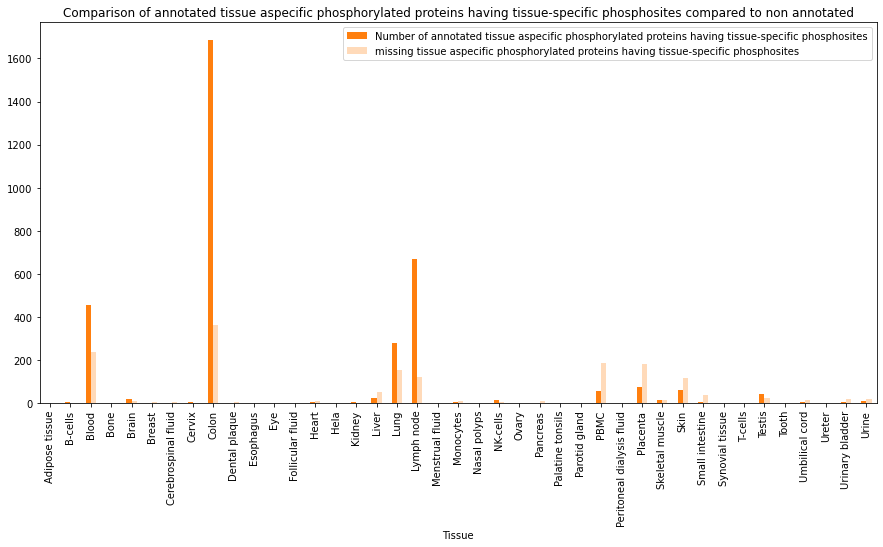

In [52]:
distr_tissues_taspec.plot(kind="bar", x="Tissue", color=["tab:orange","peachpuff"], figsize=(15,7), title="Comparison of annotated tissue aspecific phosphorylated proteins having tissue-specific phosphosites compared to non annotated")

<AxesSubplot:title={'center':'Comparison of annotated pervasively phosphorylated proteins having tissue-specific phosphosites to non annotated'}, xlabel='Tissue'>

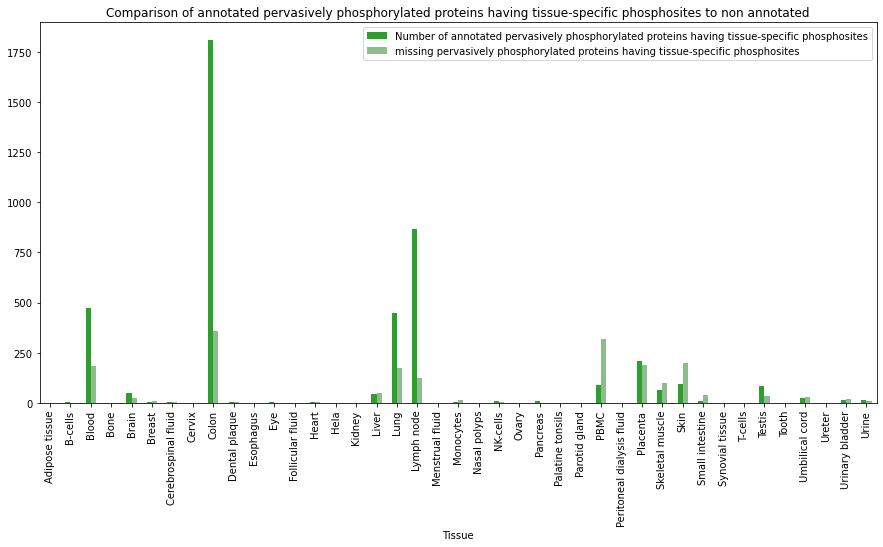

In [53]:
distr_tissues_gen.plot(kind="bar", x="Tissue", color=["tab:green", "darkseagreen"], figsize=(15,7), title="Comparison of annotated pervasively phosphorylated proteins having tissue-specific phosphosites to non annotated")

<AxesSubplot:title={'center':'Number of annotated tissue-specific phosphosites compared to non annotated ones per category'}, xlabel='Label'>

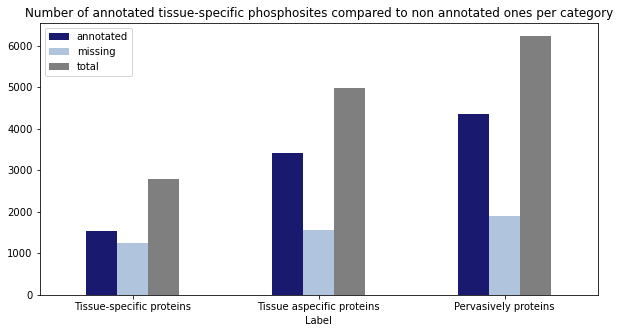

In [54]:
annotated = [tspecsites_tspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0], tspecsites_taspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0], tspecsites_genproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0]]
             
missed = [missing_tspec.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0],
          missing_nontspec.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0],
          missing_genP.groupby(["ACC_ID", "UP_POS"], as_index=False)["UP_POS"].count().shape[0]]

total = [annotated[0]+missed[0], annotated[1]+missed[1], annotated[2]+missed[2]]

three_cat = pd.DataFrame({"Label": ["Tissue-specific proteins", "Tissue aspecific proteins",
                                   "Pervasively proteins"], "annotated": annotated, "missing": missed, "total":total})
three_cat.plot(kind="bar", x="Label" ,color=["midnightblue", "lightsteelblue", "tab:grey"], figsize=(10,5), title="Number of annotated tissue-specific phosphosites compared to non annotated ones per category", rot=0)
#plt.savefig("WP2 MobiDB_ratio_annotated_tissue-specific phosphosites.png", format="png", bbox_inches="tight")

In [55]:
three_cat["ratio_annotated"] = three_cat["annotated"]*100/three_cat["total"]
three_cat

,Label,annotated,missing,total,ratio_annotated
0,Tissue-specific proteins,1548,1246,2794,55.404438
1,Tissue aspecific proteins,3420,1569,4989,68.550812
2,Pervasively proteins,4344,1892,6236,69.660038


In [56]:
print(three_cat["total"].sum())

14019


# Proteins with interaction interfaces

See also: https://www.mobidb.org/about/mobidb

We now consider P-sites occuring not in a disordered region associated with interaction interfaces (lip or linear interacting peptide and entries associated with transitions such as disorder-to-order or disorder-to-disorder). We also include predictions from ANCHOR.

In [57]:
mobi1[(((mobi1["feature"].str.contains("lip"))|(mobi1["feature"].str.contains("binding_mode"))))]["feature"].value_counts()

prediction-lip-anchor                                  57042
derived-binding_mode_disorder_to_disorder-mobi          4618
derived-binding_mode_disorder_to_disorder-priority      4613
derived-binding_mode_disorder_to_order-mobi             3779
derived-binding_mode_disorder_to_order-priority         3765
prediction-lip-priority                                 2273
derived-lip-merge                                       2248
derived-lip-th_90                                       1757
derived-lip-priority                                    1531
homology-lip-merge                                       621
curated-lip-merge                                        620
curated-lip-priority                                     618
homology-lip-priority                                    588
homology-lip-disprot                                     338
curated-lip-disprot                                      295
curated-lip-dibs                                         268
homology-lip-dibs       

In [58]:
mobi = mobi1[(((mobi1["feature"].str.contains("lip"))|
               (mobi1["feature"].str.contains("binding_mode"))))]
mobi.rename({"acc": "ACC_ID"}, inplace=True, axis=1)
print(mobi.shape[0])
mobi.head()

86622


/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1740/469402886.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mobi.rename({"acc": "ACC_ID"}, inplace=True, axis=1)


,ACC_ID,feature,start..end,content_fraction,content_count,length
24,A0A7P0T821,prediction-lip-anchor,"1..6,32..43,56..60",0.383,23,60
47,A0A7P0T8G2,prediction-lip-anchor,"13..13,26..30,60..68,116..125,146..153,171..17...",0.219,61,279
60,A0A7P0Z4R0,prediction-lip-anchor,"579..586,607..608",0.016,10,618
88,A0A7P0T9L5,prediction-lip-anchor,"12..18,339..342,405..407,476..478",0.028,17,610
105,A0A7P0TAB6,prediction-lip-anchor,"1..27,64..70,104..120",0.216,51,236


In [59]:
data_site= pd.read_csv("site_data", sep="\t")
data_site.head()

,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Small intestine,Synovial tissue,T-cells,Testis,Tooth,Umbilical cord,Ureter,Urinary bladder,Urine,Total
0,A0A075B6H7,30,Lung,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,A0A075B6S5,52,Menstrual fluid,S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,A0A087WXM9,223,Testis,S,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,A0A0B4J2D5,124,PBMC,S,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,A0A0B4J2D5,145,PBMC,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [60]:
proteins_mobi = pd.merge(mobi, data_site[["ACC_ID", "UP_POS"]], on="ACC_ID", how="inner")
print(proteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(proteins_mobi["ACC_ID"].nunique())
proteins_mobi.head()

23437
5603


,ACC_ID,feature,start..end,content_fraction,content_count,length,UP_POS
0,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,32
1,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,39
2,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,47
3,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,65
4,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,66


In [61]:
proteins_mobi1 = proteins_mobi["start..end"].str.split(",", expand=True)

In [62]:
proteins_mobi = pd.merge(proteins_mobi, proteins_mobi1, how="inner", left_index=True, right_index=True)
print(proteins_mobi.shape[0])
proteins_mobi.head()

90645


,ACC_ID,feature,start..end,content_fraction,content_count,length,UP_POS,0,1,2,...,492,493,494,495,496,497,498,499,500,501
0,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,32,25..28,46..53,95..106,...,None,None,None,None,None,None,None,None,None,None
1,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,39,25..28,46..53,95..106,...,None,None,None,None,None,None,None,None,None,None
2,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,47,25..28,46..53,95..106,...,None,None,None,None,None,None,None,None,None,None
3,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,65,25..28,46..53,95..106,...,None,None,None,None,None,None,None,None,None,None
4,P31946,prediction-lip-anchor,"25..28,46..53,95..106,121..130,173..183,218..225",0.215,53,246,66,25..28,46..53,95..106,...,None,None,None,None,None,None,None,None,None,None


In [63]:
proteins_mobi_sub_tot = pd.DataFrame({})
for i in range (502):
    proteins_mobi_sub = proteins_mobi.loc[proteins_mobi["UP_POS"].astype(float, copy=False).between(proteins_mobi[i].str.partition("..")[0].astype(float, copy=False), proteins_mobi[i].str.partition("..")[2].astype(float, copy=False))]
    proteins_mobi_sub_tot = proteins_mobi_sub_tot.append(proteins_mobi_sub, ignore_index=True)
    if i%10==0:
        print(i)

/var/folders/sq/z_sqn7bn61j9sqhwcb08v3tc0000gn/T/ipykernel_1740/2586549167.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  proteins_mobi_sub_tot = proteins_mobi_sub_tot.append(proteins_mobi_sub, ignore_index=True)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500


In [64]:
for i in range(502):
    proteins_mobi_sub_tot.drop(i, axis=1, inplace=True)
print(proteins_mobi_sub_tot.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(proteins_mobi_sub_tot["ACC_ID"].nunique())
proteins_mobi_sub_tot.head()

8914
2799


,ACC_ID,feature,start..end,content_fraction,content_count,length,UP_POS
0,P27348,derived-binding_mode_disorder_to_disorder-mobi,232..245,0.057,14,245,232
1,P27348,derived-binding_mode_disorder_to_disorder-prio...,232..245,0.057,14,245,232
2,P22314,derived-binding_mode_disorder_to_disorder-mobi,"1..48,804..815,1058..1058",0.058,61,1058,13
3,P22314,derived-binding_mode_disorder_to_disorder-mobi,"1..48,804..815,1058..1058",0.058,61,1058,46
4,P22314,derived-binding_mode_disorder_to_disorder-prio...,"1..48,804..815,1058..1058",0.058,61,1058,13


In [65]:
t_spec_sites = pd.read_csv("1.2 tissue-specific sites.tsv", sep="\t")
non_t_spec_sites = pd.read_csv("1.2 non tissue-specific sites.tsv", sep="\t")
general_P_sites = pd.read_csv("1.2 general P sites.tsv", sep="\t")

In [66]:
print(t_spec_sites.shape[0])
print(t_spec_sites["ACC_ID"].nunique())
tspec_sites_mobi = pd.merge(t_spec_sites, proteins_mobi_sub_tot, how="inner", on=["ACC_ID", "UP_POS"])
print(tspec_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspec_sites_mobi["ACC_ID"].nunique())
tspec_sites_mobi.head()

14019
4977
5093
2256


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"1..1,12..108",0.907,98,108
1,A0A1B0GTU1,760,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"91..96,117..127,132..143,152..163,188..220,237...",0.463,373,805
2,A0A1B0GTU1,762,"Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"91..96,117..127,132..143,152..163,188..220,237...",0.463,373,805
3,A0A1B0GTU1,763,"Colon,Colon",T,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"91..96,117..127,132..143,152..163,188..220,237...",0.463,373,805
4,A0AVK6,68,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"6..18,22..40,60..71,119..128,378..385,394..405...",0.300,260,867


In [67]:
print(non_t_spec_sites.shape[0])
print(non_t_spec_sites["ACC_ID"].nunique())
taspec_sites_mobi = pd.merge(non_t_spec_sites, proteins_mobi_sub_tot, how="inner", on=["ACC_ID", "UP_POS"])
print(taspec_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(taspec_sites_mobi["ACC_ID"].nunique())
taspec_sites_mobi.head()

6478
2718
2567
1269


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0AVK6,71,"Blood,Colon,Colon,Colon,Colon,Colon",S,0,0,1,0,0,0,...,0,0,0,0,2,prediction-lip-anchor,"6..18,22..40,60..71,119..128,378..385,394..405...",0.300,260,867
1,A0FGR8,738,"Liver,Liver,Liver,Liver,Blood,Testis,Lymph nod...",S,0,0,1,0,0,0,...,0,0,0,0,4,prediction-lip-anchor,"1..81,535..543,587..592,611..625,631..637,644....",0.258,238,921
2,A0FGR8,739,"Liver,Blood,Blood,Colon,Lymph node,Lymph node,...",S,0,0,1,0,0,0,...,0,0,0,0,4,prediction-lip-anchor,"1..81,535..543,587..592,611..625,631..637,644....",0.258,238,921
3,A0FGR8,758,"Liver,Liver,Blood,Testis",S,0,0,1,0,0,0,...,0,0,0,0,3,prediction-lip-anchor,"1..81,535..543,587..592,611..625,631..637,644....",0.258,238,921
4,A0FGR8,761,"Testis,Lymph node",S,0,0,0,0,0,0,...,0,0,0,0,2,prediction-lip-anchor,"1..81,535..543,587..592,611..625,631..637,644....",0.258,238,921


In [68]:
print(general_P_sites.shape[0])
print(general_P_sites["ACC_ID"].nunique())
gen_sites_mobi = pd.merge(general_P_sites, proteins_mobi_sub_tot, how="inner", on=["ACC_ID", "UP_POS"])
print(gen_sites_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(gen_sites_mobi["ACC_ID"].nunique())
gen_sites_mobi.head()

3406
1368
1254
589


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A2RU30,454,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,0,0,0,0,7,prediction-lip-anchor,"64..65,82..84,233..239,285..295,312..337,356.....",0.186,97,521
1,A5PKW4,68,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",T,0,0,1,0,1,0,...,0,0,0,0,7,prediction-lip-anchor,"1..15,39..52,60..68,96..133,142..176,181..222,...",0.501,513,1024
2,A5PKW4,133,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,0,0,0,0,7,prediction-lip-anchor,"1..15,39..52,60..68,96..133,142..176,181..222,...",0.501,513,1024
3,A5PKW4,156,"Blood, Cerebrospinal fluid, Liver, Ovary, Panc...",S,0,0,1,0,1,0,...,0,0,0,0,7,prediction-lip-anchor,"1..15,39..52,60..68,96..133,142..176,181..222,...",0.501,513,1024
4,A6NKT7,1275,"Umbilical cord,Blood,Colon,Adipose tissue, Umb...",S,1,0,1,0,0,0,...,1,0,0,0,7,prediction-lip-anchor,"32..36,320..321,718..720,764..764,788..794,809...",0.127,223,1758


# Type of feature

We'll now investigate what kind of interactions we're dealing with for each category and per tissue. Most P-sites seem to be associated with lip ordisorder-to-disorder transformations.

<AxesSubplot:title={'center':'Types of features of tissue-specific phosphosites'}, xlabel='feature'>

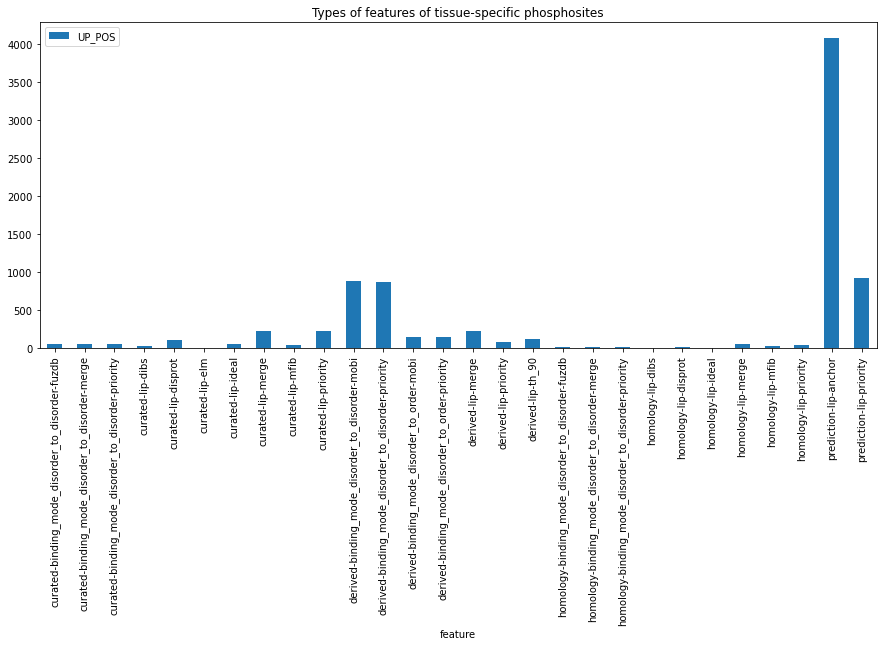

In [69]:
sub = tspec_sites_mobi.groupby(["feature", "ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"})
tspec_features = sub.groupby(["feature"], as_index=False)["UP_POS"].count()
tspec_features.plot(x="feature", kind="bar", color="tab:blue", figsize=(15,6), title="Types of features of tissue-specific phosphosites")

#There is overlap between the different categories (duplicates)

<AxesSubplot:title={'center':'Types of features of tissue aspecific phosphosites'}, xlabel='feature'>

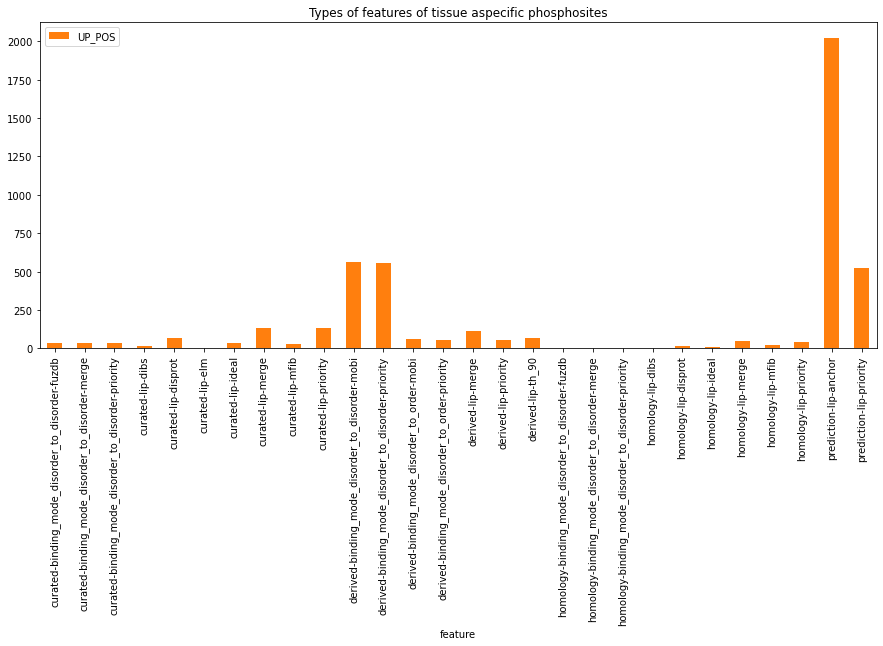

In [70]:
sub = taspec_sites_mobi.groupby(["feature", "ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"})
taspec_features = sub.groupby(["feature"], as_index=False)["UP_POS"].count()
taspec_features.plot(x="feature", kind="bar", color="tab:orange", figsize=(15,6), title="Types of features of tissue aspecific phosphosites")

#There is overlap between the different categories - some proteins are noted with both annotation from Fuzdb and homology, for example

<AxesSubplot:title={'center':'Types of features of pervasive phosphosites'}, xlabel='feature'>

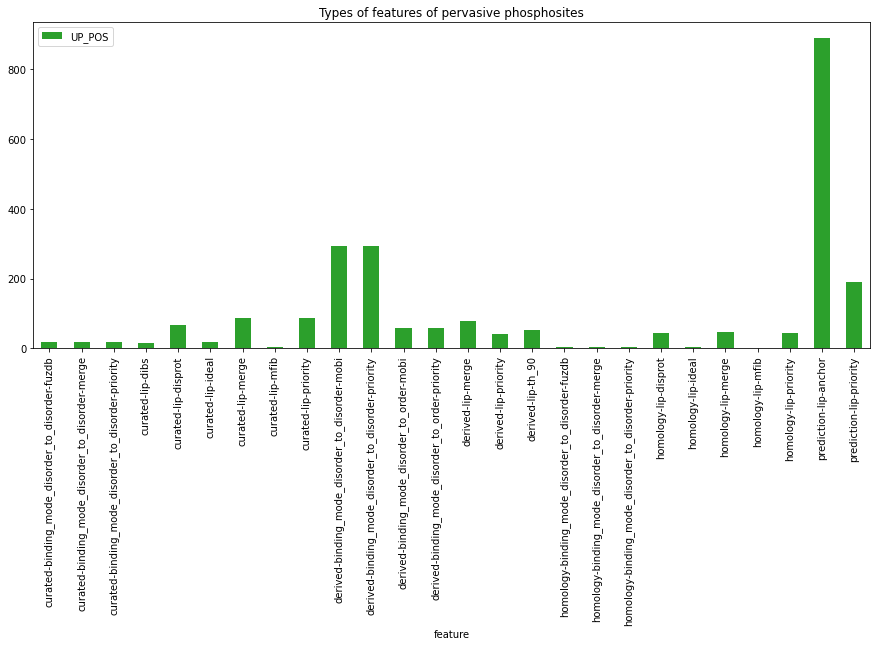

In [71]:
sub = gen_sites_mobi.groupby(["feature", "ACC_ID", "UP_POS"], as_index=False).agg({"modres": "first"})
gen_features = sub.groupby(["feature"], as_index=False)["UP_POS"].count()
gen_features.plot(x="feature", kind="bar", color="tab:green", figsize=(15,6), title="Types of features of pervasive phosphosites")

#There is overlap between the different categories - some proteins are noted with both annotation from Fuzdb and homology, for example

When considering the relative proportion of each large type of feature (lip, disorder-to-disorder and disorder-to-order), we notice by far the most P-sites are annotated with lip. This is likely the case because this is the only type of annotation for which predicitions have been taken into account.

<AxesSubplot:title={'center':'Ratio of phosphosites per type of annotation'}, xlabel='feature'>

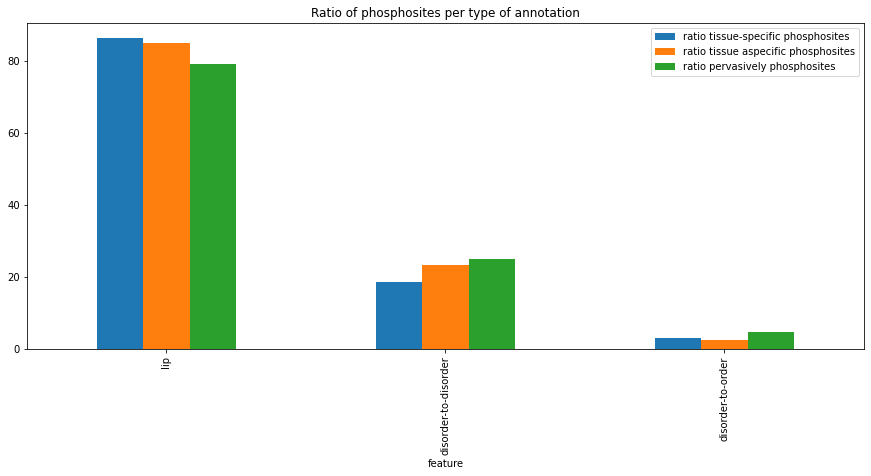

In [72]:
list_tspec = []
list_taspec = []
list_gen = []
for item in ["lip", "disorder_to_disorder", "disorder_to_order"]:
    count_item_tspec = tspec_sites_mobi.loc[tspec_sites_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count()
    count_item_taspec = taspec_sites_mobi.loc[taspec_sites_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count()
    count_item_gen = gen_sites_mobi.loc[gen_sites_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count()
    list_tspec.append(count_item_tspec*100/tspec_sites_mobi.groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count())
    list_taspec.append(count_item_taspec*100/taspec_sites_mobi.groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count())
    list_gen.append(count_item_gen*100/gen_sites_mobi.groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count())
summarised_features = pd.DataFrame({"feature": ["lip", "disorder-to-disorder", "disorder-to-order"],
                                  "ratio tissue-specific phosphosites": list_tspec,
                                  "ratio tissue aspecific phosphosites": list_taspec,
                                  "ratio pervasively phosphosites": list_gen})
summarised_features.plot(kind="bar", x="feature", figsize=(15,6), title="Ratio of phosphosites per type of annotation")
#plt.savefig("WP2 MobiDB_ratio_interaction_interfaces_P-sites.png", format="png", bbox_inches="tight")

For these P-sites identified in disordered regions associated with interaction interfaces, we have investigated the distribution across tissues (both relative and absolute, absolute first).

<AxesSubplot:title={'center':'Phosphosites of each category identified in an interaction interface'}, xlabel='Tissue'>

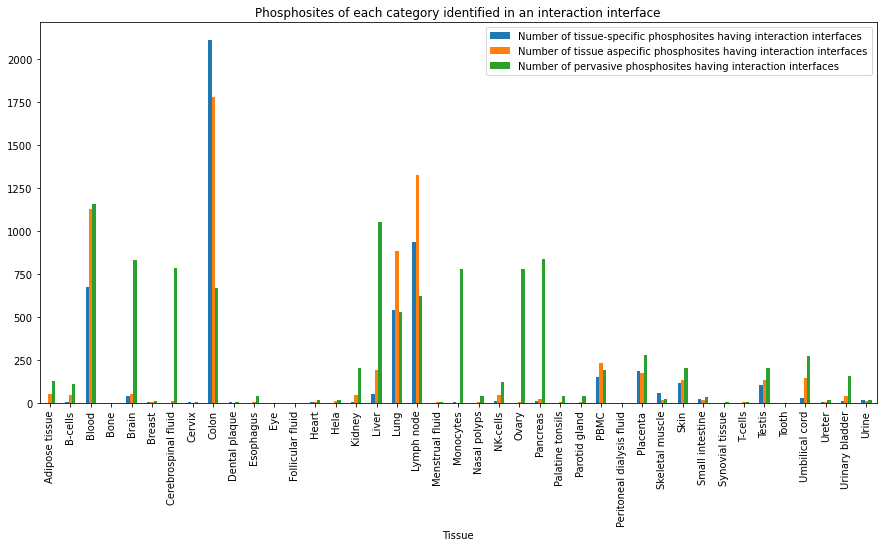

In [73]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspec_sites_mobi.loc[tspec_sites_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = taspec_sites_mobi.loc[taspec_sites_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = gen_sites_mobi.loc[gen_sites_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["UP_POS"].count()
    count_taspec = loc_taspec["UP_POS"].count()
    count_gen = loc_gen["UP_POS"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues_both = pd.DataFrame({"Tissue": list_tissues_STY, "Number of tissue-specific phosphosites having interaction interfaces": tspec_counts,
                             "Number of tissue aspecific phosphosites having interaction interfaces": taspec_counts,
                             "Number of pervasive phosphosites having interaction interfaces": gen_counts})
distr_tissues_both.plot(x="Tissue", kind="bar", figsize=(15,7), title="Phosphosites of each category identified in an interaction interface")

In [74]:
distr_tissues_both

,Tissue,Number of tissue-specific phosphosites having interaction interfaces,Number of tissue aspecific phosphosites having interaction interfaces,Number of pervasive phosphosites having interaction interfaces
0,Adipose tissue,0,49,128
1,B-cells,7,48,110
2,Blood,672,1127,1158
3,Bone,0,0,1
4,Brain,39,49,831
5,Breast,3,4,13
6,Cerebrospinal fluid,1,9,785
7,Cervix,2,1,3
8,Colon,2107,1776,667
9,Dental plaque,4,0,5


In [75]:
#distr_tissues_both.to_csv("2.3 number of phosphosites in each category per tissue in disordered regions associated with interaction interfaces")

<AxesSubplot:title={'center':'Ratio of phosphosites indentified as lip'}, xlabel='Tissue'>

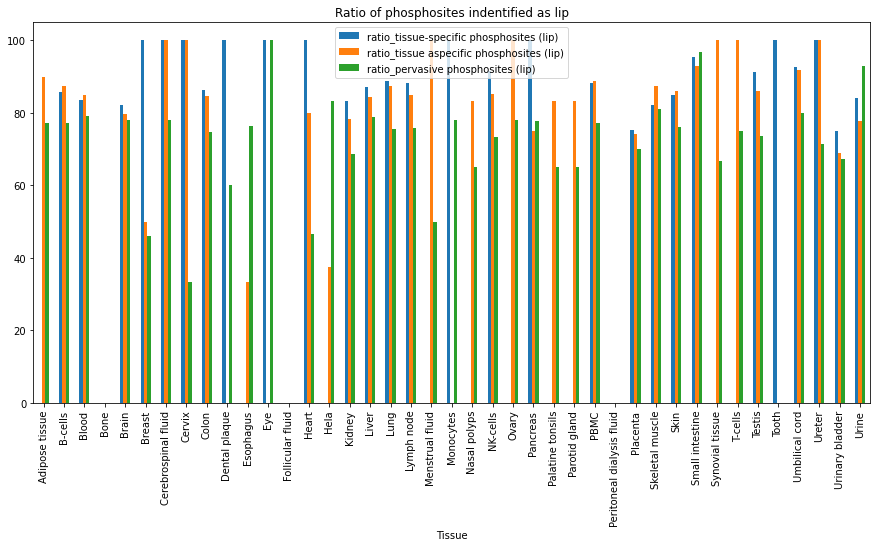

In [76]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspec_sites_mobi.loc[((tspec_sites_mobi[tissue]==1)&(tspec_sites_mobi["feature"].str.contains("lip")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = taspec_sites_mobi.loc[((taspec_sites_mobi[tissue]==1)&(taspec_sites_mobi["feature"].str.contains("lip")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = gen_sites_mobi.loc[((gen_sites_mobi[tissue]==1)&(gen_sites_mobi["feature"].str.contains("lip")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["UP_POS"].count()
    count_taspec = loc_taspec["UP_POS"].count()
    count_gen = loc_gen["UP_POS"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues_both["tissue-specific phosphosites (lip)"] = tspec_counts
distr_tissues_both["tissue aspecific phosphosites (lip)"] = taspec_counts
distr_tissues_both["pervasive phosphosites (lip)"] = gen_counts
distr_tissues_both["ratio_tissue-specific phosphosites (lip)"] = distr_tissues_both["tissue-specific phosphosites (lip)"]*100/distr_tissues_both["Number of tissue-specific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_tissue aspecific phosphosites (lip)"] = distr_tissues_both["tissue aspecific phosphosites (lip)"]*100/distr_tissues_both["Number of tissue aspecific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_pervasive phosphosites (lip)"] = distr_tissues_both["pervasive phosphosites (lip)"]*100/distr_tissues_both["Number of pervasive phosphosites having interaction interfaces"]

distr_tissues_both[["Tissue", "ratio_tissue-specific phosphosites (lip)", "ratio_tissue aspecific phosphosites (lip)",
                   "ratio_pervasive phosphosites (lip)"]].plot(x="Tissue", kind="bar", figsize=(15,7), title="Ratio of phosphosites indentified as lip")

<AxesSubplot:title={'center':'Ratio of phosphosites identified in a disorder-to-disorder region'}, xlabel='Tissue'>

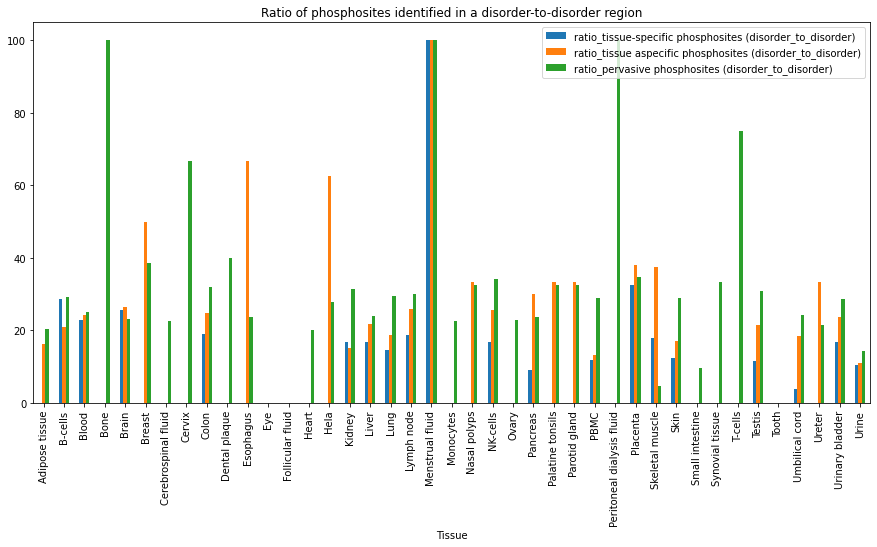

In [77]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspec_sites_mobi.loc[((tspec_sites_mobi[tissue]==1)&(tspec_sites_mobi["feature"].str.contains("disorder_to_disorder")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = taspec_sites_mobi.loc[((taspec_sites_mobi[tissue]==1)&(taspec_sites_mobi["feature"].str.contains("disorder_to_disorder")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = gen_sites_mobi.loc[((gen_sites_mobi[tissue]==1)&(gen_sites_mobi["feature"].str.contains("disorder_to_disorder")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["UP_POS"].count()
    count_taspec = loc_taspec["UP_POS"].count()
    count_gen = loc_gen["UP_POS"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues_both["tissue-specific phosphosites (disorder_to_disorder)"] = tspec_counts
distr_tissues_both["tissue aspecific phosphosites (disorder_to_disorder)"] = taspec_counts
distr_tissues_both["pervasive phosphosites (disorder_to_disorder)"] = gen_counts
distr_tissues_both["ratio_tissue-specific phosphosites (disorder_to_disorder)"] = distr_tissues_both["tissue-specific phosphosites (disorder_to_disorder)"]*100/distr_tissues_both["Number of tissue-specific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_tissue aspecific phosphosites (disorder_to_disorder)"] = distr_tissues_both["tissue aspecific phosphosites (disorder_to_disorder)"]*100/distr_tissues_both["Number of tissue aspecific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_pervasive phosphosites (disorder_to_disorder)"] = distr_tissues_both["pervasive phosphosites (disorder_to_disorder)"]*100/distr_tissues_both["Number of pervasive phosphosites having interaction interfaces"]

distr_tissues_both[["Tissue", "ratio_tissue-specific phosphosites (disorder_to_disorder)", "ratio_tissue aspecific phosphosites (disorder_to_disorder)",
                   "ratio_pervasive phosphosites (disorder_to_disorder)"]].plot(x="Tissue", kind="bar", figsize=(15,7), title="Ratio of phosphosites identified in a disorder-to-disorder region")

<AxesSubplot:title={'center':'Ratio of phosphosites identified in a disorder to order region'}, xlabel='Tissue'>

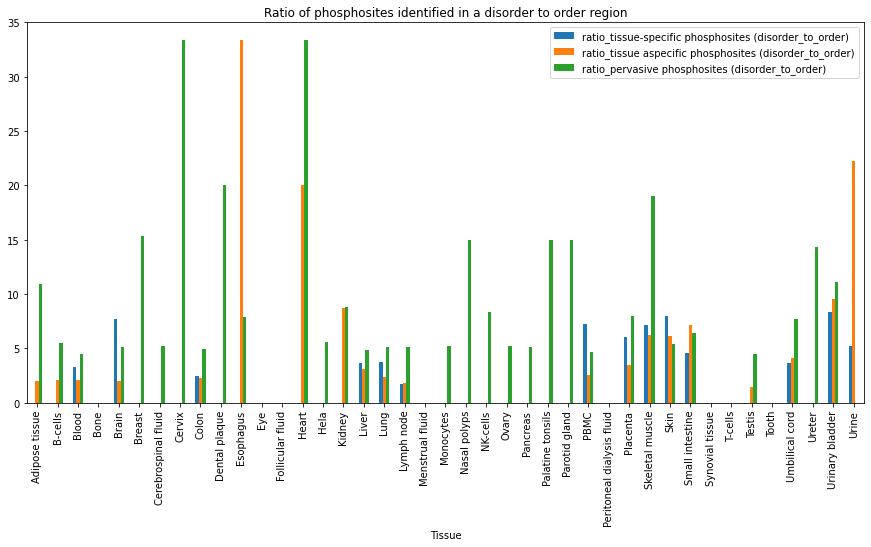

In [78]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspec_sites_mobi.loc[((tspec_sites_mobi[tissue]==1)&(tspec_sites_mobi["feature"].str.contains("disorder_to_order")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = taspec_sites_mobi.loc[((taspec_sites_mobi[tissue]==1)&(taspec_sites_mobi["feature"].str.contains("disorder_to_order")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = gen_sites_mobi.loc[((gen_sites_mobi[tissue]==1)&(gen_sites_mobi["feature"].str.contains("disorder_to_order")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["UP_POS"].count()
    count_taspec = loc_taspec["UP_POS"].count()
    count_gen = loc_gen["UP_POS"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues_both["tissue-specific phosphosites (disorder_to_order)"] = tspec_counts
distr_tissues_both["tissue aspecific phosphosites (disorder_to_order)"] = taspec_counts
distr_tissues_both["pervasive phosphosites (disorder_to_order)"] = gen_counts
distr_tissues_both["ratio_tissue-specific phosphosites (disorder_to_order)"] = distr_tissues_both["tissue-specific phosphosites (disorder_to_order)"]*100/distr_tissues_both["Number of tissue-specific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_tissue aspecific phosphosites (disorder_to_order)"] = distr_tissues_both["tissue aspecific phosphosites (disorder_to_order)"]*100/distr_tissues_both["Number of tissue aspecific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_pervasive phosphosites (disorder_to_order)"] = distr_tissues_both["pervasive phosphosites (disorder_to_order)"]*100/distr_tissues_both["Number of pervasive phosphosites having interaction interfaces"]

distr_tissues_both[["Tissue", "ratio_tissue-specific phosphosites (disorder_to_order)", "ratio_tissue aspecific phosphosites (disorder_to_order)",
                   "ratio_pervasive phosphosites (disorder_to_order)"]].plot(x="Tissue", kind="bar", figsize=(15,7), title="Ratio of phosphosites identified in a disorder to order region")

As LIP is the only feature for which predictions are included, more P-sites are associated with that feature.

# Comparison of the ratio of disorderedness

We'll compare the amount of P-sites found on proteins associated with disordered regions to the amount of UniProtKB proteins.

In [79]:
tspec_sites_mobi = pd.merge(t_spec_sites, proteins_mobi, on=["ACC_ID"], how="inner")
print(tspec_sites_mobi["ACC_ID"].nunique())
taspec_sites_mobi = pd.merge(non_t_spec_sites, proteins_mobi, on=["ACC_ID"], how="inner")
print(taspec_sites_mobi["ACC_ID"].nunique())
gen_sites_mobi = pd.merge(general_P_sites, proteins_mobi, on=["ACC_ID"], how="inner")
print(gen_sites_mobi["ACC_ID"].nunique())

Uniprot = pd.read_csv("UniprotKB_GO_human_mannually annotated.tab", sep="\t")
Uniprot.rename({"Entry": "ACC_ID"}, axis=1, inplace=True)
Uniprot_mobi = pd.merge(Uniprot["ACC_ID"], mobi, on=["ACC_ID"], how="inner")
print(Uniprot_mobi["ACC_ID"].nunique())

4780
2639
1331
17272


<AxesSubplot:title={'center':'Number of P-sites having tissue-specific phosphosites associated with a type of annotation'}, xlabel='feature'>

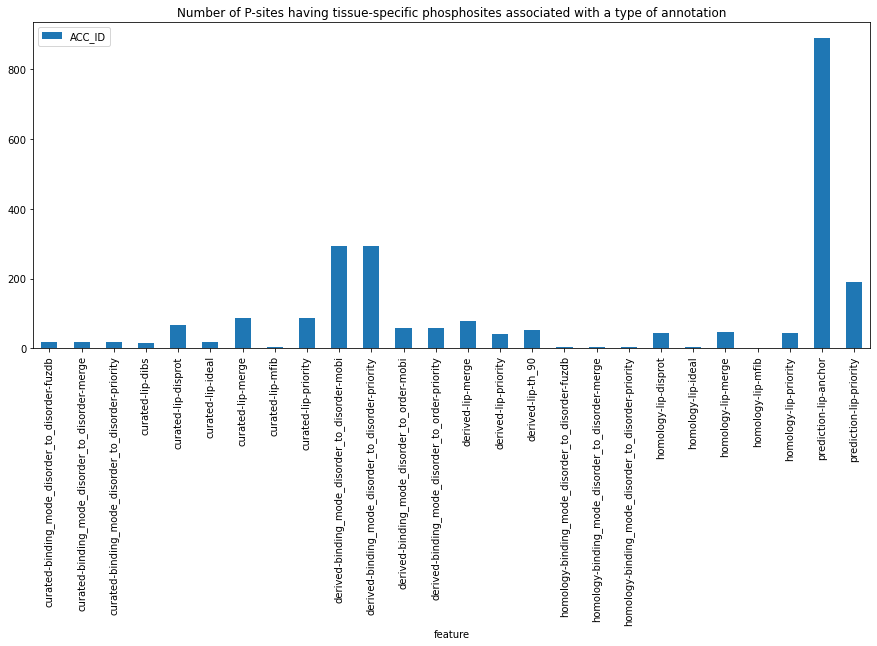

In [80]:
sub1 = tspec_sites_mobi.groupby(["feature", "ACC_ID", "UP_POS_x"], as_index=False).agg({"modres": "first"})
tspec_features = sub.groupby(["feature"], as_index=False)["ACC_ID"].count()
tspec_features.plot(x="feature", kind="bar", color="tab:blue", figsize=(15,6), title="Number of P-sites having tissue-specific phosphosites associated with a type of annotation")

<AxesSubplot:title={'center':'Number of P-sites having tissue aspecific phosphosites associated with a type of annotation'}, xlabel='feature'>

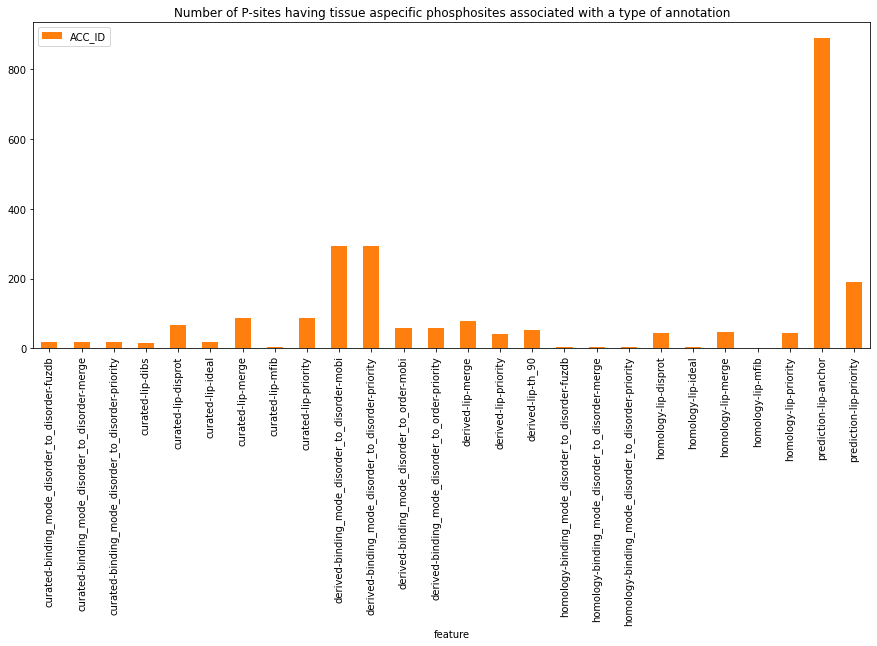

In [81]:
sub2 = taspec_sites_mobi.groupby(["feature", "ACC_ID", "UP_POS_x"], as_index=False).agg({"modres": "first"})
taspec_features = sub.groupby(["feature"], as_index=False)["ACC_ID"].count()
taspec_features.plot(x="feature", kind="bar", color="tab:orange", figsize=(15,6), title="Number of P-sites having tissue aspecific phosphosites associated with a type of annotation")

<AxesSubplot:title={'center':'Number of proteins having pervasive phosphosites associated with a type of annotation'}, xlabel='feature'>

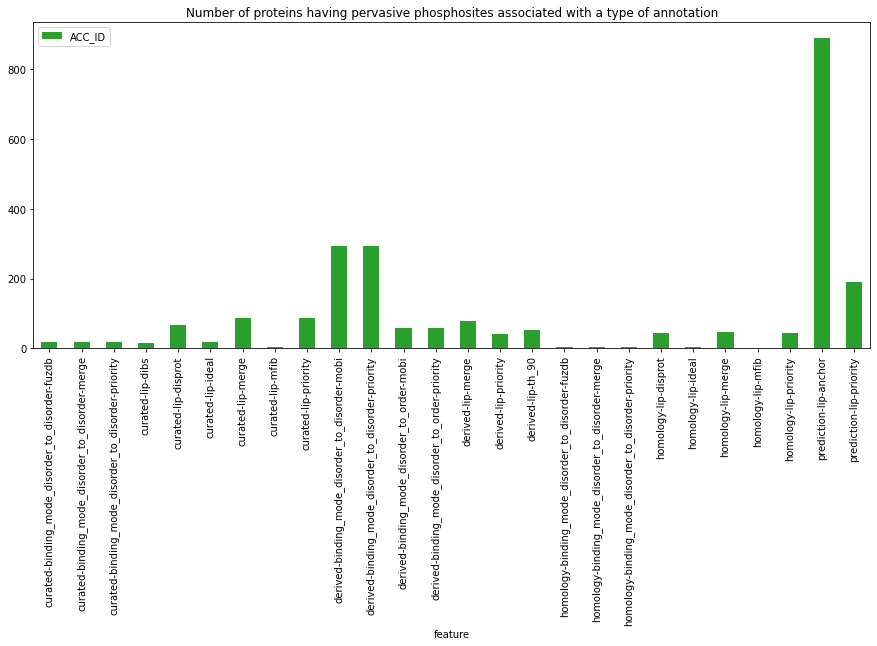

In [82]:
sub3 = gen_sites_mobi.groupby(["feature", "ACC_ID", "UP_POS_x"], as_index=False).agg({"modres": "first"})
gen_features = sub.groupby(["feature"], as_index=False)["ACC_ID"].count()
gen_features.plot(x="feature", kind="bar", color="tab:green", figsize=(15,6), title="Number of proteins having pervasive phosphosites associated with a type of annotation")

<AxesSubplot:title={'center':'Number of proteins from UniProt associated with a type of annotation'}, xlabel='feature'>

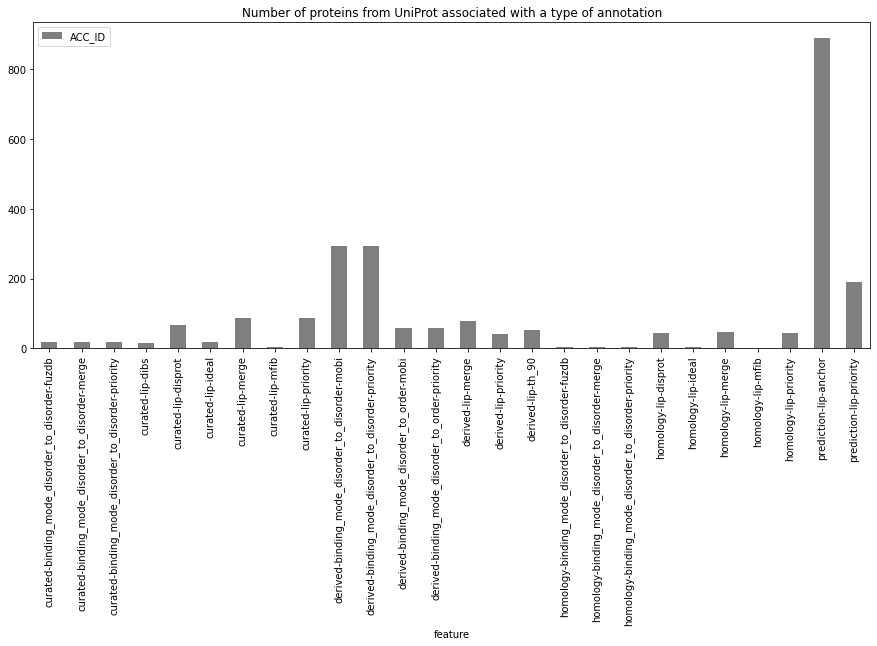

In [83]:
sub4 = Uniprot_mobi.groupby(["feature", "ACC_ID"], as_index=False).agg({"length": "first"})
Uniprot_features = sub.groupby(["feature"], as_index=False)["ACC_ID"].count()
Uniprot_features.plot(x="feature", kind="bar", color="tab:grey", figsize=(15,6), title="Number of proteins from UniProt associated with a type of annotation")

In [84]:
print(sub1["UP_POS_x"].count()*100/sub4["ACC_ID"].count())
print(sub2["UP_POS_x"].count()*100/sub4["ACC_ID"].count())
print(sub3["UP_POS_x"].count()*100/sub4["ACC_ID"].count())

119.06731252570488
58.19357492117169
29.85193986199333


<AxesSubplot:title={'center':'Ratio of P-sites having a category of phosphosites per type of annotation'}, xlabel='feature'>

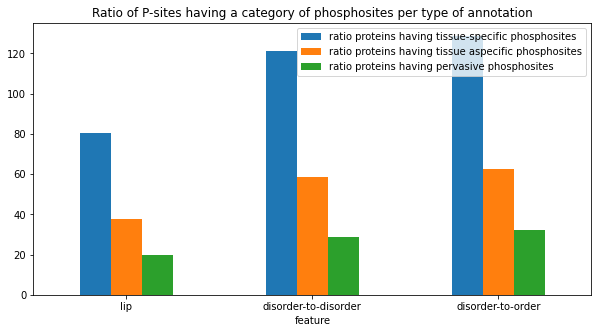

In [85]:
list_tspec = []
list_taspec = []
list_gen = []
for item in ["lip", "disorder_to_disorder", "disorder_to_order"]:
    count_item_tspec = tspec_sites_mobi.loc[tspec_sites_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS_x"], as_index=False).agg({"length": "first"})["ACC_ID"].count()
    count_item_taspec = taspec_sites_mobi.loc[taspec_sites_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS_x"], as_index=False).agg({"length": "first"})["ACC_ID"].count()
    count_item_gen = gen_sites_mobi.loc[gen_sites_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS_x"], as_index=False).agg({"length": "first"})["ACC_ID"].count()
    count_item_Uniprot = Uniprot_mobi.loc[Uniprot_mobi["feature"].str.contains(item), :].groupby(["ACC_ID"], as_index=False).agg({"length": "first"})["ACC_ID"].count()
    list_tspec.append(count_item_tspec*100/count_item_Uniprot)
    list_taspec.append(count_item_taspec*100/count_item_Uniprot)
    list_gen.append(count_item_gen*100/count_item_Uniprot)
summarised_features = pd.DataFrame({"feature": ["lip", "disorder-to-disorder", "disorder-to-order"],
                                  "ratio proteins having tissue-specific phosphosites": list_tspec,
                                  "ratio proteins having tissue aspecific phosphosites": list_taspec,
                                  "ratio proteins having pervasive phosphosites": list_gen})
summarised_features.plot(kind="bar", x="feature", figsize=(10,5), title="Ratio of P-sites having a category of phosphosites per type of annotation", rot=0)
#plt.savefig("WP2 MobiDB interaction interfaces all phosphosites.png", format="png", bbox_inches="tight")

# Comparison of proteins having tissue-specific phosphosites

As before, we consider the tissue-specific P-sites on the three categories of proteins seperately.

In [86]:
tspec_proteins = pd.read_csv("1.1 tissue-specific proteins.tsv", sep="\t")
print(tspec_proteins.shape[0])
taspec_proteins = pd.read_csv("1.1 non tissue-specific proteins.tsv", sep="\t")
print(taspec_proteins.shape[0])
gen_proteins = pd.read_csv("1.1 general P proteins", sep="\t")
print(gen_proteins.shape[0])

2029
2074
1752


In [87]:
tspec_sites_mobi = pd.merge(t_spec_sites, proteins_mobi_sub_tot, on=["ACC_ID", "UP_POS"], how="inner")
tspecsites_tspecproteins_mobi = pd.merge(tspec_sites_mobi, tspec_proteins["ACC_ID"], on=["ACC_ID"], how="inner")
print(tspecsites_tspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspecsites_tspecproteins_mobi["ACC_ID"].nunique())
tspecsites_tspecproteins_mobi.head()

779
595


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0A0U1RRK4,41,Testis,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"1..1,12..108",0.907,98,108
1,A0A1B0GTU1,760,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"91..96,117..127,132..143,152..163,188..220,237...",0.463,373,805
2,A0A1B0GTU1,762,"Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"91..96,117..127,132..143,152..163,188..220,237...",0.463,373,805
3,A0A1B0GTU1,763,"Colon,Colon",T,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"91..96,117..127,132..143,152..163,188..220,237...",0.463,373,805
4,A1A5D9,371,Lung,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"1..3,7..39,50..72,181..194,240..243,263..273,2...",0.350,178,508


In [88]:
tspecsites_taspecproteins_mobi = pd.merge(tspec_sites_mobi, taspec_proteins["ACC_ID"], on=["ACC_ID"], how="inner")
print(tspecsites_taspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspecsites_taspecproteins_mobi["ACC_ID"].nunique())
tspecsites_taspecproteins_mobi.head()

1857
859


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0AVK6,68,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"6..18,22..40,60..71,119..128,378..385,394..405...",0.300,260,867
1,A0JLT2,192,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",T,0,0,0,0,0,0,...,0,0,0,0,1,derived-binding_mode_disorder_to_disorder-mobi,"1..62,165..244",0.582,142,244
2,A0JLT2,192,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",T,0,0,0,0,0,0,...,0,0,0,0,1,derived-binding_mode_disorder_to_disorder-prio...,"1..62,165..244",0.582,142,244
3,A0JLT2,194,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,derived-binding_mode_disorder_to_disorder-mobi,"1..62,165..244",0.582,142,244
4,A0JLT2,194,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colon",S,0,0,0,0,0,0,...,0,0,0,0,1,derived-binding_mode_disorder_to_disorder-prio...,"1..62,165..244",0.582,142,244


In [89]:
tspecsites_genproteins_mobi = pd.merge(tspec_sites_mobi, gen_proteins["ACC_ID"], on=["ACC_ID"], how="inner")
print(tspecsites_genproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspecsites_genproteins_mobi["ACC_ID"].nunique())
tspecsites_genproteins_mobi.head()

2457
802


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,Umbilical cord,Ureter,Urinary bladder,Urine,Total,feature,start..end,content_fraction,content_count,length
0,A0FGR8,736,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"1..81,535..543,587..592,611..625,631..637,644....",0.258,238,921
1,A0FGR8,737,Colon,S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"1..81,535..543,587..592,611..625,631..637,644....",0.258,238,921
2,A0FGR8,743,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,0,0,0,0,1,prediction-lip-anchor,"1..81,535..543,587..592,611..625,631..637,644....",0.258,238,921
3,A6NMY6,31,Skin,T,0,0,0,0,0,0,...,0,0,0,0,1,homology-lip-disprot,2..33,0.094,32,339
4,A6NMY6,31,Skin,T,0,0,0,0,0,0,...,0,0,0,0,1,homology-lip-merge,1..33,0.097,33,339


We compare the percentage tissue-specific P-sites identified per type of MobiDB annotation (lip, disorder-to-disorder, disoder-to-order) to the total amount of tissue-specific P-sites, per category of proteins these tissue-specific P-sites have been identified on. This is similar for each category of proteins.

<AxesSubplot:title={'center':'Ratio phosphosites associated with each of the three major categories of annotation'}, xlabel='feature'>

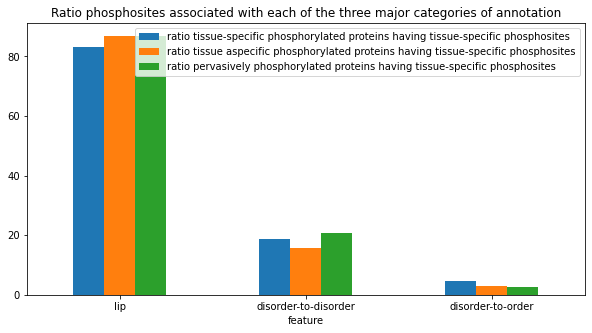

In [90]:
list_tspec = []
list_taspec = []
list_gen = []
for item in ["lip", "disorder_to_disorder", "disorder_to_order"]:
    count_item_tspec = tspecsites_tspecproteins_mobi.loc[tspecsites_tspecproteins_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count()
    count_item_taspec = tspecsites_taspecproteins_mobi.loc[tspecsites_taspecproteins_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count()
    count_item_gen = tspecsites_genproteins_mobi.loc[tspecsites_genproteins_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count()
    list_tspec.append(count_item_tspec*100/tspecsites_tspecproteins_mobi.groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count())
    list_taspec.append(count_item_taspec*100/tspecsites_taspecproteins_mobi.groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count())
    list_gen.append(count_item_gen*100/tspecsites_genproteins_mobi.groupby(["ACC_ID", "UP_POS"],as_index=False)["length"].mean()["UP_POS"].count())
summarised_features = pd.DataFrame({"feature": ["lip", "disorder-to-disorder", "disorder-to-order"],
                                  "ratio tissue-specific phosphorylated proteins having tissue-specific phosphosites": list_tspec,
                                  "ratio tissue aspecific phosphorylated proteins having tissue-specific phosphosites": list_taspec,
                                  "ratio pervasively phosphorylated proteins having tissue-specific phosphosites": list_gen})
summarised_features.plot(kind="bar", x="feature", figsize=(10,5), title="Ratio phosphosites associated with each of the three major categories of annotation", rot=0)

<AxesSubplot:title={'center':'Number of phosphosites occuring in an interaction interface per tissue'}, xlabel='Tissue'>

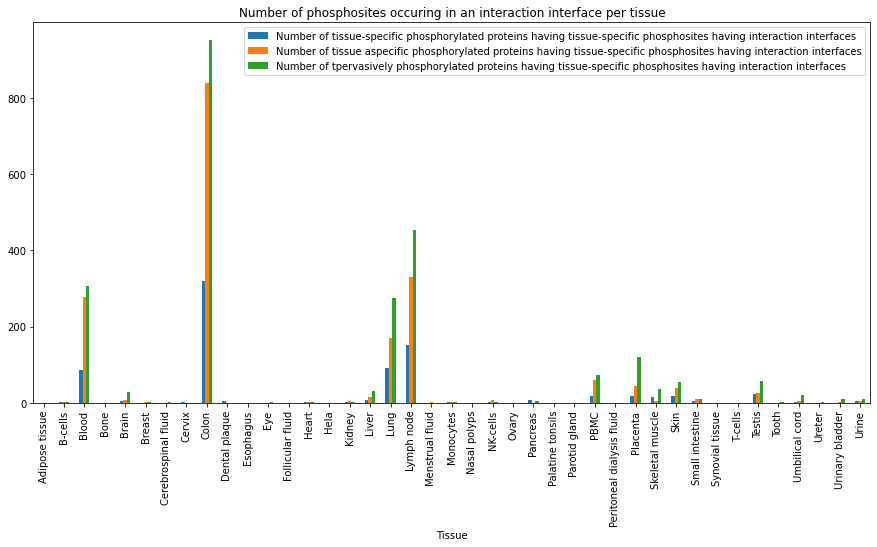

In [91]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspecsites_tspecproteins_mobi.loc[tspecsites_tspecproteins_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = tspecsites_taspecproteins_mobi.loc[tspecsites_taspecproteins_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = tspecsites_genproteins_mobi.loc[tspecsites_genproteins_mobi[tissue]==1].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["UP_POS"].count()
    count_taspec = loc_taspec["UP_POS"].count()
    count_gen = loc_gen["UP_POS"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues_both = pd.DataFrame({"Tissue": list_tissues_STY, "Number of tissue-specific phosphorylated proteins having tissue-specific phosphosites having interaction interfaces": tspec_counts,
                             "Number of tissue aspecific phosphorylated proteins having tissue-specific phosphosites having interaction interfaces": taspec_counts,
                             "Number of tpervasively phosphorylated proteins having tissue-specific phosphosites having interaction interfaces": gen_counts})
distr_tissues_both.plot(x="Tissue", kind="bar", figsize=(15,7), title="Number of phosphosites occuring in an interaction interface per tissue")

<AxesSubplot:title={'center':'Ratio phosphosites associated with lip'}, xlabel='Tissue'>

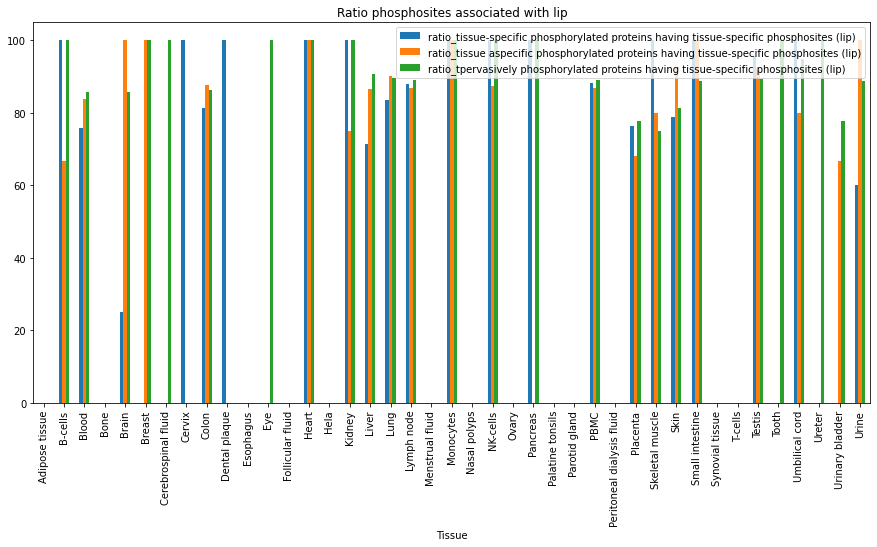

In [92]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspecsites_tspecproteins_mobi.loc[((tspecsites_tspecproteins_mobi[tissue]==1)&(tspecsites_tspecproteins_mobi["feature"].str.contains("lip")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = tspecsites_taspecproteins_mobi.loc[((tspecsites_taspecproteins_mobi[tissue]==1)&(tspecsites_taspecproteins_mobi["feature"].str.contains("lip")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = tspecsites_genproteins_mobi.loc[((tspecsites_genproteins_mobi[tissue]==1)&(tspecsites_genproteins_mobi["feature"].str.contains("lip")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["UP_POS"].count()
    count_taspec = loc_taspec["UP_POS"].count()
    count_gen = loc_gen["UP_POS"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues_both["tissue-specific phosphorylated proteins having tissue-specific phosphosites (lip)"] = tspec_counts
distr_tissues_both["tissue aspecific phosphorylated proteins having tissue-specific phosphosites (lip)"] = taspec_counts
distr_tissues_both["tpervasively phosphorylated proteins having tissue-specific phosphosites (lip)"] = gen_counts
distr_tissues_both["ratio_tissue-specific phosphorylated proteins having tissue-specific phosphosites (lip)"] = distr_tissues_both["tissue-specific phosphorylated proteins having tissue-specific phosphosites (lip)"]*100/distr_tissues_both["Number of tissue-specific phosphorylated proteins having tissue-specific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_tissue aspecific phosphorylated proteins having tissue-specific phosphosites (lip)"] = distr_tissues_both["tissue aspecific phosphorylated proteins having tissue-specific phosphosites (lip)"]*100/distr_tissues_both["Number of tissue aspecific phosphorylated proteins having tissue-specific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_tpervasively phosphorylated proteins having tissue-specific phosphosites (lip)"] = distr_tissues_both["tpervasively phosphorylated proteins having tissue-specific phosphosites (lip)"]*100/distr_tissues_both["Number of tpervasively phosphorylated proteins having tissue-specific phosphosites having interaction interfaces"]

distr_tissues_both[["Tissue", "ratio_tissue-specific phosphorylated proteins having tissue-specific phosphosites (lip)", "ratio_tissue aspecific phosphorylated proteins having tissue-specific phosphosites (lip)",
                   "ratio_tpervasively phosphorylated proteins having tissue-specific phosphosites (lip)"]].plot(x="Tissue", kind="bar", figsize=(15,7), title="Ratio phosphosites associated with lip")

<AxesSubplot:title={'center':'Ratio phosphosites occuring in a region transitioning from disorder-to-disorder'}, xlabel='Tissue'>

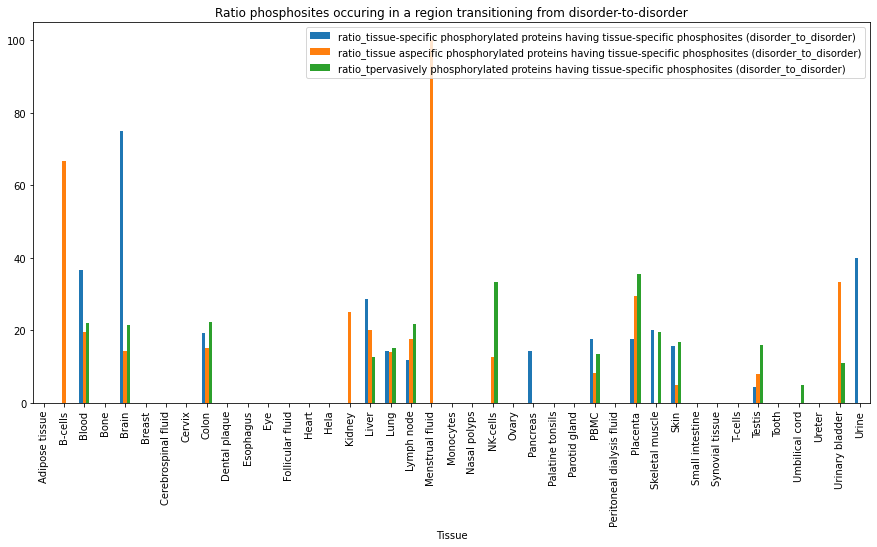

In [93]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspecsites_tspecproteins_mobi.loc[((tspecsites_tspecproteins_mobi[tissue]==1)&(tspecsites_tspecproteins_mobi["feature"].str.contains("disorder_to_disorder")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = tspecsites_taspecproteins_mobi.loc[((tspecsites_taspecproteins_mobi[tissue]==1)&(tspecsites_taspecproteins_mobi["feature"].str.contains("disorder_to_disorder")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = tspecsites_genproteins_mobi.loc[((tspecsites_genproteins_mobi[tissue]==1)&(tspecsites_genproteins_mobi["feature"].str.contains("disorder_to_disorder")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["UP_POS"].count()
    count_taspec = loc_taspec["UP_POS"].count()
    count_gen = loc_gen["UP_POS"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues_both["tissue-specific phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"] = tspec_counts
distr_tissues_both["tissue aspecific phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"] = taspec_counts
distr_tissues_both["tpervasively phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"] = gen_counts
distr_tissues_both["ratio_tissue-specific phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"] = distr_tissues_both["tissue-specific phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"]*100/distr_tissues_both["Number of tissue-specific phosphorylated proteins having tissue-specific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_tissue aspecific phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"] = distr_tissues_both["tissue aspecific phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"]*100/distr_tissues_both["Number of tissue aspecific phosphorylated proteins having tissue-specific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_tpervasively phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"] = distr_tissues_both["tpervasively phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"]*100/distr_tissues_both["Number of tpervasively phosphorylated proteins having tissue-specific phosphosites having interaction interfaces"]

distr_tissues_both[["Tissue", "ratio_tissue-specific phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)", "ratio_tissue aspecific phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)",
                   "ratio_tpervasively phosphorylated proteins having tissue-specific phosphosites (disorder_to_disorder)"]].plot(x="Tissue", kind="bar", figsize=(15,7), title="Ratio phosphosites occuring in a region transitioning from disorder-to-disorder")

<AxesSubplot:title={'center':'Ratio phosphosites occuring in a region transitioning from disorder to order'}, xlabel='Tissue'>

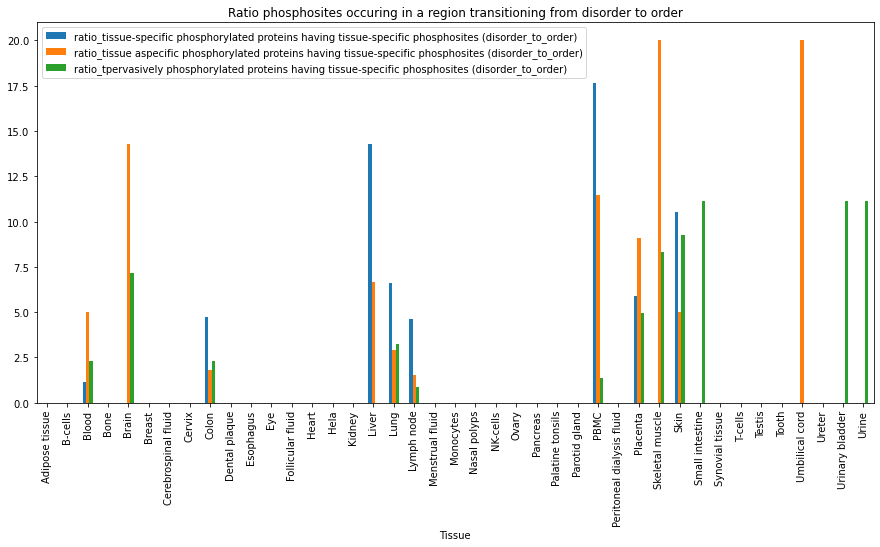

In [94]:
tspec_counts = []
taspec_counts = []
gen_counts = []
for tissue in list_tissues_STY:
    loc_tspec = tspecsites_tspecproteins_mobi.loc[((tspecsites_tspecproteins_mobi[tissue]==1)&(tspecsites_tspecproteins_mobi["feature"].str.contains("disorder_to_order")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_taspec = tspecsites_taspecproteins_mobi.loc[((tspecsites_taspecproteins_mobi[tissue]==1)&(tspecsites_taspecproteins_mobi["feature"].str.contains("disorder_to_order")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    loc_gen = tspecsites_genproteins_mobi.loc[((tspecsites_genproteins_mobi[tissue]==1)&(tspecsites_genproteins_mobi["feature"].str.contains("disorder_to_order")))].groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean()
    count_tspec = loc_tspec["UP_POS"].count()
    count_taspec = loc_taspec["UP_POS"].count()
    count_gen = loc_gen["UP_POS"].count()
    tspec_counts.append(count_tspec)
    taspec_counts.append(count_taspec)
    gen_counts.append(count_gen)
distr_tissues_both["tissue-specific phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"] = tspec_counts
distr_tissues_both["tissue aspecific phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"] = taspec_counts
distr_tissues_both["tpervasively phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"] = gen_counts
distr_tissues_both["ratio_tissue-specific phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"] = distr_tissues_both["tissue-specific phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"]*100/distr_tissues_both["Number of tissue-specific phosphorylated proteins having tissue-specific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_tissue aspecific phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"] = distr_tissues_both["tissue aspecific phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"]*100/distr_tissues_both["Number of tissue aspecific phosphorylated proteins having tissue-specific phosphosites having interaction interfaces"]
distr_tissues_both["ratio_tpervasively phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"] = distr_tissues_both["tpervasively phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"]*100/distr_tissues_both["Number of tpervasively phosphorylated proteins having tissue-specific phosphosites having interaction interfaces"]

distr_tissues_both[["Tissue", "ratio_tissue-specific phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)", "ratio_tissue aspecific phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)",
                   "ratio_tpervasively phosphorylated proteins having tissue-specific phosphosites (disorder_to_order)"]].plot(x="Tissue", kind="bar", figsize=(15,7), title="Ratio phosphosites occuring in a region transitioning from disorder to order")

# Comparison wiht UniProtKB

In [95]:
tspec_sites_mobi = pd.merge(t_spec_sites, proteins_mobi, on=["ACC_ID", "UP_POS"], how="inner")
tspecsites_tspecproteins_mobi = pd.merge(tspec_sites_mobi, tspec_proteins["ACC_ID"], on=["ACC_ID"], how="inner")
print(tspecsites_tspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspecsites_tspecproteins_mobi["ACC_ID"].nunique())
tspecsites_tspecproteins_mobi.head()

2634
1896


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,492,493,494,495,496,497,498,499,500,501
0,A0A075B6H7,30,Lung,T,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
1,A0A087WXM9,223,Testis,S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
2,A0A0B4J2D5,124,PBMC,S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
3,A0A0B4J2D5,145,PBMC,T,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
4,A0A0B4J2F2,435,Placenta,S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None


In [96]:
tspecsites_taspecproteins_mobi = pd.merge(tspec_sites_mobi, taspec_proteins["ACC_ID"], on=["ACC_ID"], how="inner")
print(tspecsites_taspecproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspecsites_taspecproteins_mobi["ACC_ID"].nunique())
tspecsites_taspecproteins_mobi.head()

4899
1556


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,492,493,494,495,496,497,498,499,500,501
0,A0AVK6,68,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
1,A0AVK6,68,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
2,A0AVK6,68,"Colon,Colon,Colon",S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
3,A0JLT2,192,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",T,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
4,A0JLT2,192,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",T,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None


In [97]:
tspecsites_genproteins_mobi = pd.merge(tspec_sites_mobi, gen_proteins["ACC_ID"], on=["ACC_ID"], how="inner")
print(tspecsites_genproteins_mobi.groupby(["ACC_ID", "UP_POS"], as_index=False)["length"].mean().shape[0])
print(tspecsites_genproteins_mobi["ACC_ID"].nunique())
tspecsites_genproteins_mobi.head()

6186
1328


,ACC_ID,UP_POS,tissue,modres,Adipose tissue,B-cells,Blood,Bone,Brain,Breast,...,492,493,494,495,496,497,498,499,500,501
0,A0FGR8,736,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
1,A0FGR8,736,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
2,A0FGR8,736,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
3,A0FGR8,736,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None
4,A0FGR8,736,"Colon,Colon,Colon,Colon,Colon,Colon,Colon,Colo...",S,0,0,0,0,0,0,...,None,None,None,None,None,None,None,None,None,None


In [98]:
print(Uniprot_mobi["ACC_ID"].nunique())

17272


<AxesSubplot:title={'center':'Ratio phosphosites associated with each of the three major categories of annotation'}, xlabel='feature'>

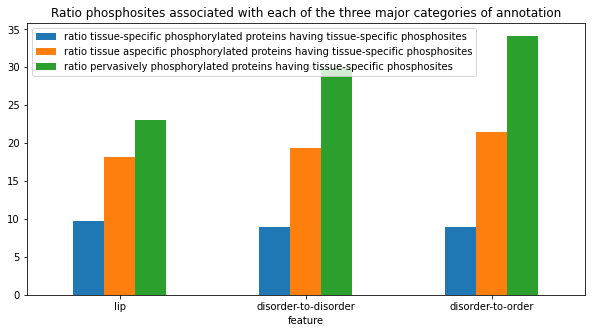

In [99]:
list_tspec = []
list_taspec = []
list_gen = []
for item in ["lip", "disorder_to_disorder", "disorder_to_order"]:
    count_item_tspec = tspecsites_tspecproteins_mobi.loc[tspecsites_tspecproteins_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"length": "first"})["ACC_ID"].count()
    count_item_taspec = tspecsites_taspecproteins_mobi.loc[tspecsites_taspecproteins_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"length": "first"})["ACC_ID"].count()
    count_item_gen = tspecsites_genproteins_mobi.loc[tspecsites_genproteins_mobi["feature"].str.contains(item), :].groupby(["ACC_ID", "UP_POS"], as_index=False).agg({"length": "first"})["ACC_ID"].count()
    count_item_uniprot = Uniprot_mobi.loc[Uniprot_mobi["feature"].str.contains(item),"ACC_ID"].count()
    list_tspec.append(count_item_tspec*100/count_item_uniprot)
    list_taspec.append(count_item_taspec*100/count_item_uniprot)
    list_gen.append(count_item_gen*100/count_item_uniprot)
summarised_features = pd.DataFrame({"feature": ["lip", "disorder-to-disorder", "disorder-to-order"],
                                  "ratio tissue-specific phosphorylated proteins having tissue-specific phosphosites": list_tspec,
                                  "ratio tissue aspecific phosphorylated proteins having tissue-specific phosphosites": list_taspec,
                                  "ratio pervasively phosphorylated proteins having tissue-specific phosphosites": list_gen})
summarised_features.plot(kind="bar", x="feature", figsize=(10,5), title="Ratio phosphosites associated with each of the three major categories of annotation", rot=0)
#plt.savefig("WP2 MobiDB_Ratio proteins having tissue-specific phosphosites interaction interface.png", format="png", bbox_inches="tight")